# Module 4 Final Project: Top Zip Codes for Investment Properties

Student name: **Cynthia Pedrasa**  
Student pace: **self paced**  
Scheduled project review date/time:  **Wed, Dec 18, 2019 7:00pm - 7:30pm (EDT)**  
Instructor name: **Eli Thomas**  
Blog post URL:  https://cpedrasa.github.io/racial_bias_in_machine_learning_algorithm

## Table of contents

**Problem Description** - The question we are trying to answer as a consultant in the Real-Estate Investment Firm is as follows:  
"What are the top 5 zip codes nationwide with the highest Return on Investment (ROI) in 5 years 
that are within accepted standard deviation threshold (low volatility or variability in returns)?"    

The dataset provides the monthly average house sales price nationwide   
from April 1996 to April 2018 or just under 10 years of data.   
The Values are the average price and there are 1329 observations.  The data set is credited to Zillow.  

Understanding the limitations of our data and what potential questions can be answered by data is important and will help define the scope or goal for this project.  

**Data** We have monthly average house price for given zip codes(RegionName) for given dates.   

**Questions we will try to answer**    

* Find the top 5 zip codes nationwide with the highest ROI within accepted standard deviation threshold (variability in returns)  
* Forecast the future house pricing for top 5 zipcodes  


I. Data Preparation
  + Import the Libraries 
  + Load and Explore the Time Series Data
  + Inspect the Data Types
  + Inspect the column values
  + Find the top 5 Zip Codes for forecasting
  
II. Feature Engineering
  + Data Visualization 
  + Power transform
  + Rolling Statistics, Moving Average, Smoothing 


III. Time Series Structure 
  + Decompose
  + Detrend
  + Remove Seasonality
  + Stationarity
  
IV. Evaluate Models
  + Evaluate the performance of predictions using the root mean squared error (RMSE)
  + Train - Test Split
  + Forecasting RMSE
  + Visualize Residuals 

V. Forecast Models
  + Predicting House Price in the next 5 years




# Data Preparation  

## Import the Libraries

In [1]:
#import packages
import warnings
warnings.filterwarnings('ignore') #ignore the warnings to avoid a lot of noise from running the procedure
import pandas as pd
from pandas import Series
from pandas import Grouper 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
plt.style.use('ggplot')
import seaborn as sns
import folium

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

import scipy
import statsmodels
import math

from statsmodels.tsa.stattools import adfuller #Augmented Dickey Fuller Test

import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

## Load and Explore the Time Series Data

In [2]:
# Load the zillow_data.csv data set
rdf = pd.read_csv('zillow_data.csv', header=0, index_col=None, parse_dates=True,squeeze=True)

#Look at the data 
display(rdf.head())

#Look at the shape of data
display(rdf.shape)

# of columns, #of rows
display(rdf.info())

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2         3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3         4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

(14723, 272)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


None

## Inspect the Data Types

In [3]:
#Let's check the data types of the first seven columns. See if any columns have nulls.
print(rdf.loc[:, 'RegionID':'SizeRank'].info())
#display(df.iloc[:7,:7].dtypes)
print('\n')

#Let's check the unique data types for all date columns after SizeRank
print('Date columns have data types of :',rdf.iloc[8:271,8:271].dtypes.unique())

# display descriptive statistics
display(rdf.describe(percentiles=[0.25,0.5,0.75,0.85,0.95,0.99]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Data columns (total 7 columns):
RegionID      14723 non-null int64
RegionName    14723 non-null int64
City          14723 non-null object
State         14723 non-null object
Metro         13680 non-null object
CountyName    14723 non-null object
SizeRank      14723 non-null int64
dtypes: int64(3), object(4)
memory usage: 805.2+ KB
None


Date columns have data types of : [dtype('float64') dtype('int64')]


RegionID    RegionName      SizeRank       1996-04       1996-05  \
count   14723.000000  14723.000000  14723.000000  1.368400e+04  1.368400e+04   
mean    81075.010052  48222.348706   7362.000000  1.182991e+05  1.184190e+05   
std     31934.118525  29359.325439   4250.308342  8.600251e+04  8.615567e+04   
min     58196.000000   1001.000000      1.000000  1.130000e+04  1.150000e+04   
25%     67174.500000  22101.500000   3681.500000  6.880000e+04  6.890000e+04   
50%     78007.000000  46106.000000   7362.000000  9.950000e+04  9.950000e+04   
75%     90920.500000  75205.500000  11042.500000  1.432000e+05  1.433000e+05   
85%     94999.700000  85233.700000  12514.700000  1.743550e+05  1.743000e+05   
95%     98870.900000  95818.900000  13986.900000  2.545000e+05  2.547000e+05   
99%    100166.780000  98583.120000  14575.780000  4.132510e+05  4.145340e+05   
max    753844.000000  99901.000000  14723.000000  3.676700e+06  3.704200e+06   

            1996-06       1996-07       1996-08       1996-09       1996-10  \
count  1.368400e+04  1.368400e+04  1.368400e+04  1.368400e+04  1.368400e+04   
mean   1.185374e+05  1.186531e+05  1.187803e+05  1.189275e+05  1.191205e+05   
std    8.630923e+04  8.646795e+04  8.665094e+04  8.687208e+04  8.715185e+04   
min    1.160000e+04  1.180000e+04  1.180000e+04  1.200000e+04  1.210000e+04   
25%    6.910000e+04  6.920000e+04  6.937500e+04  6.950000e+04  6.960000e+04   
50%    9.970000e+04  9.970000e+04  9.980000e+04  9.990000e+04  9.995000e+04   
75%    1.432250e+05  1.432250e+05  1.435000e+05  1.437000e+05  1.439000e+05   
85%    1.743550e+05  1.742550e+05  1.743000e+05  1.743550e+05  1.746000e+05   
95%    2.547000e+05  2.551000e+05  2.553000e+05  2.557700e+05  2.557850e+05   
99%    4.164380e+05  4.171190e+05  4.167740e+05  4.182190e+05  4.204870e+05   
max    3.729600e+06  3.754600e+06  3.781800e+06  3.813500e+06  3.849600e+06   

       ...       2017-07       2017-08       2017-09       2017-10  \
count  ...  1.472300e+04  1.472300e+04  1.472300e+04  1.472300e+04   
mean   ...  2.733354e+05  2.748658e+05  2.764646e+05  2.780332e+05   
std    ...  3.603984e+05  3.614678e+05  3.627563e+05  3.644610e+05   
min    ...  1.440000e+04  1.450000e+04  1.470000e+04  1.480000e+04   
25%    ...  1.269000e+05  1.275000e+05  1.282000e+05  1.287000e+05   
50%    ...  1.884000e+05  1.896000e+05  1.905000e+05  1.914000e+05   
75%    ...  3.050000e+05  3.066500e+05  3.085000e+05  3.098000e+05   
85%    ...  4.117700e+05  4.134000e+05  4.153000e+05  4.170000e+05   
95%    ...  7.252700e+05  7.275000e+05  7.299800e+05  7.352400e+05   
99%    ...  1.480348e+06  1.499586e+06  1.498910e+06  1.512708e+06   
max    ...  1.888990e+07  1.870350e+07  1.860530e+07  1.856940e+07   

            2017-11       2017-12       2018-01       2018-02       2018-03  \
count  1.472300e+04  1.472300e+04  1.472300e+04  1.472300e+04  1.472300e+04   
mean   2.795209e+05  2.810953e+05  2.826571e+05  2.843687e+05  2.865114e+05   
std    3.656003e+05  3.670454e+05  3.695727e+05  3.717739e+05  3.724612e+05   
min    1.450000e+04  1.430000e+04  1.410000e+04  1.390000e+04  1.380000e+04   
25%    1.292500e+05  1.299000e+05  1.306000e+05  1.310500e+05  1.319500e+05   
50%    1.925000e+05  1.934000e+05  1.941000e+05  1.950000e+05  1.967000e+05   
75%    3.117000e+05  3.134000e+05  3.151000e+05  3.168500e+05  3.188500e+05   
85%    4.186000e+05  4.208100e+05  4.232400e+05  4.254000e+05  4.280700e+05   
95%    7.383500e+05  7.439800e+05  7.497900e+05  7.539900e+05  7.594900e+05   
99%    1.531004e+06  1.535202e+06  1.545114e+06  1.556330e+06  1.578478e+06   
max    1.842880e+07  1.830710e+07  1.836590e+07  1.853040e+07  1.833770e+07   

            2018-04  
count  1.472300e+04  
mean   2.880399e+05  
std    3.720544e+05  
min    1.380000e+04  
25%    1.324000e+05  
50%    1.981000e+05  
75%    3.211000e+05  
85%    4.307700e+05  
95%    7.632500e+05  
99%    1.597666e+06  
max    1.789490e+07  

[11 rows x 268 columns]

In [4]:
#Let's summarize
print('How many rows are in the dataset?' ,len(rdf))
print('How many columns are in this dataset?', len(rdf.columns))
print('What\'s the total # of entries?',rdf.size)
print('How many are null values?',rdf.isna().sum().sum())
print('What is the proportion of null values?', round((rdf.isna().sum().sum()/rdf.size) *100,1),"%")


How many rows are in the dataset? 14723
How many columns are in this dataset? 272
What's the total # of entries? 4004656
How many are null values? 157934
What is the proportion of null values? 3.9 %


## Inspect the column values - Check Zip Code Validity

In [5]:
#Let's check validity of zip codes
rdf["RegionName"]= rdf["RegionName"].astype(str) 
booleans = []
for z in rdf.RegionName:
    if len(z) == 5:
        booleans.append(True)
    else:
        booleans.append(False)
booleans[0:5]
is_valid = pd.Series(booleans)
print('There are',len(rdf[~is_valid]),'zipcodes with len <> 5. This comprised', len(rdf[~is_valid])/len(rdf)*100, '%')

display(rdf[~is_valid].head())

There are 1403 zipcodes with len <> 5. This comprised 9.529307885621137 %


RegionID RegionName      City State     Metro CountyName  SizeRank  \
57      60545       7030   Hoboken    NJ  New York     Hudson        58   
73      61148       8701  Lakewood    NJ  New York      Ocean        74   
88      58669       2169    Quincy    MA    Boston    Norfolk        89   
112     60081       6010   Bristol    CT  Hartford   Hartford       113   
149     58660       2148    Malden    MA    Boston  Middlesex       150   

      1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  2017-10  \
57   301600.0  302700.0  303800.0  ...  1789100  1803000  1818100  1836900   
73   153800.0  153400.0  153000.0  ...   400500   403900   408400   411000   
88   137800.0  137900.0  137900.0  ...   416900   417800   421100   425100   
112  120300.0  120000.0  119800.0  ...   188900   190000   191200   191800   
149  130600.0  130700.0  130800.0  ...   439100   442400   446700   451400   

     2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
57   1850100  1853500  1852200  1854400  1857600  1854300  
73    412600   414000   415700   415600   413400   410700  
88    428600   431900   435700   440500   445800   449100  
112   192900   193600   194100   194900   195700   195700  
149   454700   457700   461900   466000   469300   471100  

[5 rows x 272 columns]

After checking validity of these 4-digit codes, it seems the leading zero is truncated, but they are valid zipcodes


In [6]:
#Let's make a copy of our database as we will look at some calculated fields for selecting top 5 zip codes
dfs=rdf.copy()
dfs.dropna(inplace=True)
dfs.shape

(12895, 272)

## Find the Top 5 Zip Codes: 
### Estimate Future Value, Appreciation, and ROI 

https://www.mashvisor.com/blog/how-to-calculate-real-estate-appreciation/   

To get the current HousePriceIndex go to:  
https://www.fhfa.gov/AboutUs/Reports/ReportDocuments/HPI_August2019.pdf   

**Step 1:** - Look up the FHFA House Price Index for each State to calculate Future Growth for 5 years needed to calculate Future Value to estimate real estate appreciation   
**Step 2:** Calculate Future Value and Appreciation.  Example:  

Comparative market analysis returned a fair market value of $150,000 on a potential investment property. A real estate investor plans to hold onto the rental property for 5 years before selling. Let’s see how much the future value of real estate will be thanks to appreciation:

Future Growth = (1 + 0.034)^5

Future Growth = 1.18

Future Value = (1.18) x (150,000)

Future Value = $177,000

**Step 3:** Consider Market Volatility in making the final selection    
In five years, the investment property will be worth approximately $177,000.  
ROI Formula: (how much we buy it) - (how much you sell for) divide by (original price)  

ROI can be impacted by the following factors:  
+ impact on return by transaction cost        
+ taxes- 20% capital gain tax or more  
+ time -  50% over 5 years compiunded rate in 8-8.5%   
+ inflation  
+ real return over nominal return   
+ opportunity cost - what would you have done with the money had you not made the investment    

In [7]:
#Since our data is current only as of April 2018, let's get an estimate of Future Growth 
#by adding 1 to US Housing Price index and increase to the power of 5
#to estimate appreciation in 5 years
q1 = """SELECT *, (([2018-04] - [1996-04])/ [1996-04])*100 as Incr_rate ,
        CASE WHEN State in ( 'HI', 'AK', 'WA', 'OR', 'CA')
        THEN  1.211     --((1+0.039)**5)
        WHEN  State in ( 'MT', 'ID', 'WY', 'NV', 'UT', 'CO', 'AZ', 'NM') 
        THEN 1.370   --((1+0.065)**5)
        WHEN  State in ( 'ND', 'SD', 'MN', 'NE', 'IA', 'KS', 'MO') 
        THEN 1.258 --((1+0.047)**5)
        WHEN  State in ( 'OK', 'AR', 'TX', 'LA' ) 
        THEN 1.258  --((1+0.047)**5)
        WHEN  State in ( 'MI', 'WI', 'IL', 'IN', 'ID', 'OH') 
        THEN 1.295 --((1+0.053)**5)
        WHEN  State in ( 'KY', 'TN', 'MS', 'AL') 
        THEN 1.217 --((1+0.04)**5)
        WHEN  State in ( 'ME', 'NH', 'VT', 'MA', 'RI','CT') 
        THEN 1.276 --((1+0.05)**5)
        WHEN  State in ( 'NY', 'PA',  'NJ') 
        THEN 1.211 --((1+0.039)**5)
        WHEN  State in ( 'DE', 'MD', 'DC', 'VA', 'WV','NC', 'SC', 'GA', 'FL') 
        THEN 1.228 --((1+0.042)**5) ELSE 1
        END as FutureGrowth
        FROM dfs WHERE Incr_rate > 0 
        ORDER BY Incr_rate DESC;"""
df_hpi = pysqldf(q1)
# Calculate the estimated Future Value, Appreciation and ROI
q2 = """SELECT *,  
    (FutureGrowth * [2018-04]) as FutureValue, 
     ((FutureGrowth * [2018-04]) - [2018-04]) as Appreciation,
     (((FutureGrowth * [2018-04]) - [2018-04]) / [2018-04])*100 as ROI 
     FROM df_hpi Order by ROI DESC;"""
df2 = pysqldf(q2)
df2.head()

RegionID RegionName          City State     Metro CountyName  SizeRank  \
0     93288      80211        Denver    CO    Denver     Denver      1388   
1     93314      80238        Denver    CO    Denver     Denver      5359   
2     93280      80203        Denver    CO    Denver     Denver      1941   
3     95167      86323  Chino Valley    AZ  Prescott    Yavapai      5728   
4     93296      80220        Denver    CO    Denver     Denver      1249   

    1996-04   1996-05   1996-06  ...  2017-12  2018-01  2018-02  2018-03  \
0   91400.0   92000.0   92600.0  ...   522900   527600   532900   540600   
1  131300.0  131700.0  132200.0  ...   588400   591800   597100   605800   
2  134000.0  134800.0  135700.0  ...   540300   546200   553700   563300   
3   68500.0   67500.0   66600.0  ...   272900   276300   279500   283700   
4  138500.0  139700.0  141000.0  ...   535400   541000   547200   554800   

   2018-04   Incr_rate  FutureGrowth  FutureValue  Appreciation   ROI  
0   546600  498.030635          1.37     748842.0      202242.0  37.0  
1   612500  366.488957          1.37     839125.0      226625.0  37.0  
2   571500  326.492537          1.37     782955.0      211455.0  37.0  
3   286400  318.102190          1.37     392368.0      105968.0  37.0  
4   561100  305.126354          1.37     768707.0      207607.0  37.0  

[5 rows x 277 columns]

##  Inspect the Top 10 zip codes with highest ROI and check for variability in returns

In [8]:

#https://www.wallstreetmojo.com/realized-volatility/
'''Realized volatility is the assessment of variation in returns for an investment product by analyzing its historical returns within a defined time period. Assessment of degree of uncertainty and/or potential financial loss/gain from investing in a firm may be measured using variability/ volatility in stock prices of the entity. In statistics, the most common measure to determine variability is by measuring the standard deviation, i.e variability of returns from the mean. It is an indicator of the actual price risk.'''
#Calculate historical mean value
df2['mean']=df2.loc[:,'1996-04':'2018-04'].mean(axis=1)
#Calculate std to assess variability in housing proces/volatility
df2['std']=df2.loc[:,'1996-04':'2018-04'].std(axis=1)

#Calculate coefficient of variance
df2['cv']=df2['std']/df2['mean']
#Show calculated values
dftop10 = df2[['RegionName','City','State','std','mean','ROI','cv','Incr_rate']].head(10)
display(dftop10.head(10),dftop10[['std','cv']].describe())



RegionName          City State            std           mean   ROI  \
0      80211        Denver    CO  105640.100259  266817.735849  37.0   
1      80238        Denver    CO  121816.956436  361813.584906  37.0   
2      80203        Denver    CO   97015.695731  303763.018868  37.0   
3      86323  Chino Valley    AZ   72121.064559  170715.094340  37.0   
4      80220        Denver    CO   93434.675399  303921.132075  37.0   
5      80010        Aurora    CO   44931.176263  140930.188679  37.0   
6      80808        Calhan    CO   40307.448251  153405.660377  37.0   
7      80514        Dacono    CO   45834.352674  152158.867925  37.0   
8      86325     Cornville    AZ   77342.794461  194768.301887  37.0   
9      85020       Phoenix    AZ   62835.442423  187018.867925  37.0   

         cv   Incr_rate  
0  0.395926  498.030635  
1  0.336684  366.488957  
2  0.319380  326.492537  
3  0.422464  318.102190  
4  0.307431  305.126354  
5  0.318819  294.318182  
6  0.262751  264.713715  
7  0.301227  263.694268  
8  0.397102  234.857143  
9  0.335985  230.392157

std         cv
count      10.000000  10.000000
mean    76127.970646   0.339777
std     28012.980720   0.050134
min     40307.448251   0.262751
25%     50084.625111   0.310278
50%     74731.929510   0.327682
75%     96120.440648   0.381116
max    121816.956436   0.422464

###  Inspect the TOP 5 zip codes after estimating future real estate appreciation using the Federal House Finance Agency  House Price Index (HPI)  and eliminating zip codes with high standard deviation/covariance which is a measure of HP volatility

In [9]:

q3= '''SELECT * 
       FROM df2 
       WHERE RegionName IN 
           (SELECT RegionName 
            FROM dftop10 
            WHERE  cv < .4 
            ORDER BY ROI DESC, Incr_rate DESC,  cv ASC)
       ORDER BY ROI DESC, Incr_rate DESC,  cv ASC;'''
ds = pysqldf(q3).head(5)
ds.head()


RegionID RegionName    City State   Metro CountyName  SizeRank   1996-04  \
0     93288      80211  Denver    CO  Denver     Denver      1388   91400.0   
1     93314      80238  Denver    CO  Denver     Denver      5359  131300.0   
2     93280      80203  Denver    CO  Denver     Denver      1941  134000.0   
3     93296      80220  Denver    CO  Denver     Denver      1249  138500.0   
4     93200      80010  Aurora    CO  Denver   Arapahoe      2471   70400.0   

    1996-05   1996-06  ...  2018-03  2018-04   Incr_rate  FutureGrowth  \
0   92000.0   92600.0  ...   540600   546600  498.030635          1.37   
1  131700.0  132200.0  ...   605800   612500  366.488957          1.37   
2  134800.0  135700.0  ...   563300   571500  326.492537          1.37   
3  139700.0  141000.0  ...   554800   561100  305.126354          1.37   
4   70800.0   71400.0  ...   274100   277600  294.318182          1.37   

   FutureValue  Appreciation   ROI           mean            std        cv  
0     748842.0      202242.0  37.0  266817.735849  105640.100259  0.395926  
1     839125.0      226625.0  37.0  361813.584906  121816.956436  0.336684  
2     782955.0      211455.0  37.0  303763.018868   97015.695731  0.319380  
3     768707.0      207607.0  37.0  303921.132075   93434.675399  0.307431  
4     380312.0      102712.0  37.0  140930.188679   44931.176263  0.318819  

[5 rows x 280 columns]

### The top 5 zip codes with the highest ROI are all located in Denver Colorado.
These zip codes are 80211, 80238, 80203, 80220, and 80010.

In [10]:
#Let's remove all the calculated columns
ds = ds.loc[:, 'RegionID':'2018-04']
ds

RegionID RegionName    City State   Metro CountyName  SizeRank   1996-04  \
0     93288      80211  Denver    CO  Denver     Denver      1388   91400.0   
1     93314      80238  Denver    CO  Denver     Denver      5359  131300.0   
2     93280      80203  Denver    CO  Denver     Denver      1941  134000.0   
3     93296      80220  Denver    CO  Denver     Denver      1249  138500.0   
4     93200      80010  Aurora    CO  Denver   Arapahoe      2471   70400.0   

    1996-05   1996-06  ...  2017-07  2017-08  2017-09  2017-10  2017-11  \
0   92000.0   92600.0  ...   501000   504500   507500   511100   516600   
1  131700.0  132200.0  ...   577800   579000   579500   580900   583700   
2  134800.0  135700.0  ...   515900   520100   523700   528900   534200   
3  139700.0  141000.0  ...   517400   518900   520900   524700   529400   
4   70800.0   71400.0  ...   252200   254000   255700   257700   260600   

   2017-12  2018-01  2018-02  2018-03  2018-04  
0   522900   527600   532900   540600   546600  
1   588400   591800   597100   605800   612500  
2   540300   546200   553700   563300   571500  
3   535400   541000   547200   554800   561100  
4   264000   266500   269500   274100   277600  

[5 rows x 272 columns]

## Reshape our dataframe from wide format into long format 

In [11]:

#ds.drop(['std', 'mean', 'cv','ROI'], axis=1 ,inplace=True)
dfm = pd.melt(ds, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName','SizeRank'], var_name="Date", value_name="Value")
dfm['Date'] = pd.to_datetime(dfm['Date'], infer_datetime_format=True)
dfm = dfm.dropna(subset=['Value'])

dfm.info()
dfm.head() 
#3744704 rows × 9 columns
#dfm.to_csv('zillowmelt_datacopy.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1325 entries, 0 to 1324
Data columns (total 9 columns):
RegionID      1325 non-null int64
RegionName    1325 non-null object
City          1325 non-null object
State         1325 non-null object
Metro         1325 non-null object
CountyName    1325 non-null object
SizeRank      1325 non-null int64
Date          1325 non-null datetime64[ns]
Value         1325 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 103.5+ KB


RegionID RegionName    City State   Metro CountyName  SizeRank       Date  \
0     93288      80211  Denver    CO  Denver     Denver      1388 1996-04-01   
1     93314      80238  Denver    CO  Denver     Denver      5359 1996-04-01   
2     93280      80203  Denver    CO  Denver     Denver      1941 1996-04-01   
3     93296      80220  Denver    CO  Denver     Denver      1249 1996-04-01   
4     93200      80010  Aurora    CO  Denver   Arapahoe      2471 1996-04-01   

      Value  
0   91400.0  
1  131300.0  
2  134000.0  
3  138500.0  
4   70400.0

In [12]:
#Let's remove the other attributes except for Date, Values, and Zip code
dfm.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName','SizeRank'], axis=1, inplace=True)
display(dfm.head(),dfm.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1325 entries, 0 to 1324
Data columns (total 3 columns):
RegionName    1325 non-null object
Date          1325 non-null datetime64[ns]
Value         1325 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 41.4+ KB


RegionName       Date     Value
0      80211 1996-04-01   91400.0
1      80238 1996-04-01  131300.0
2      80203 1996-04-01  134000.0
3      80220 1996-04-01  138500.0
4      80010 1996-04-01   70400.0

None

# Exploring the Time Series

In [13]:
#Let's print the datatype of dts and also first 5 entries of dts dataframe as our first ts exploratory step.
# Confirm that date values are used for indexing purpose in the dts dataset 
dfm = dfm.rename(columns = {'Date': 'ds', 'Value': 'ts'})
dts = dfm.set_index('ds')
print(type(dts))
print(dts.head(15))
dts.index

<class 'pandas.core.frame.DataFrame'>
           RegionName        ts
ds                             
1996-04-01      80211   91400.0
1996-04-01      80238  131300.0
1996-04-01      80203  134000.0
1996-04-01      80220  138500.0
1996-04-01      80010   70400.0
1996-05-01      80211   92000.0
1996-05-01      80238  131700.0
1996-05-01      80203  134800.0
1996-05-01      80220  139700.0
1996-05-01      80010   70800.0
1996-06-01      80211   92600.0
1996-06-01      80238  132200.0
1996-06-01      80203  135700.0
1996-06-01      80220  141000.0
1996-06-01      80010   71400.0


DatetimeIndex(['1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-05-01', '1996-05-01', '1996-05-01',
               '1996-05-01', '1996-05-01',
               ...
               '2018-03-01', '2018-03-01', '2018-03-01', '2018-03-01',
               '2018-03-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01'],
              dtype='datetime64[ns]', name='ds', length=1325, freq=None)

## Time Series Descriptive Statistics

In [14]:
#Let's check the decsriptive statistics for the top 5 zipcodes
dts.groupby('RegionName').ts.agg(['count','sum','median','mean','var','std','min','max'])


count         sum    median           mean           var  \
RegionName                                                             
80010         265  37346500.0  139100.0  140930.188679  2.018811e+09   
80203         265  80497200.0  298100.0  303763.018868  9.412045e+09   
80211         265  70706700.0  264800.0  266817.735849  1.115983e+10   
80220         265  80539100.0  301900.0  303921.132075  8.730039e+09   
80238         265  95880600.0  382300.0  361813.584906  1.483937e+10   

                      std       min       max  
RegionName                                     
80010        44931.176263   70400.0  277600.0  
80203        97015.695731  134000.0  571500.0  
80211       105640.100259   91400.0  546600.0  
80220        93434.675399  138500.0  561100.0  
80238       121816.956436  131300.0  612500.0

In [15]:
display(dts.head(),dts.info())
display(dts.describe())
dts.RegionName.value_counts()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1325 entries, 1996-04-01 to 2018-04-01
Data columns (total 2 columns):
RegionName    1325 non-null object
ts            1325 non-null float64
dtypes: float64(1), object(1)
memory usage: 71.1+ KB


RegionName        ts
ds                             
1996-04-01      80211   91400.0
1996-04-01      80238  131300.0
1996-04-01      80203  134000.0
1996-04-01      80220  138500.0
1996-04-01      80010   70400.0

None

ts
count    1325.000000
mean   275449.132075
std    121063.794048
min     70400.000000
25%    162800.000000
50%    271100.000000
75%    341300.000000
max    612500.000000

80220    265
80010    265
80211    265
80203    265
80238    265
Name: RegionName, dtype: int64

In [16]:

top5_zip =  ['80211', '80238',  '80203', '80220', '80010'] 

# Data Visualization

### Map the top 5 zip codes with the best ROI and low standard deviation/variation

In [17]:

map1 = folium.Map([39.7313, -104.95102], zoom_start = 12.25)

# CircleMarker with radius 
folium.CircleMarker(location = [39.766499, -105.020401], 
                    radius = 50, popup = '80211').add_to(map1) 
folium.CircleMarker(location = [39.760601, -104.903297], 
                    radius = 50, popup = '80238').add_to(map1) 
folium.CircleMarker(location = [39.7313, -104.981102], 
                    radius = 50, popup = '80203').add_to(map1) 
folium.CircleMarker(location = [39.731201, -104.912903], 
                    radius = 50, popup = '80220').add_to(map1) 
folium.CircleMarker(location = [39.679001, -104.963097], 
                    radius = 50, popup = '80210').add_to(map1) 
# save as html 
#map1.save(" my_map2.html ") 
figsize = (20, 18)
map1


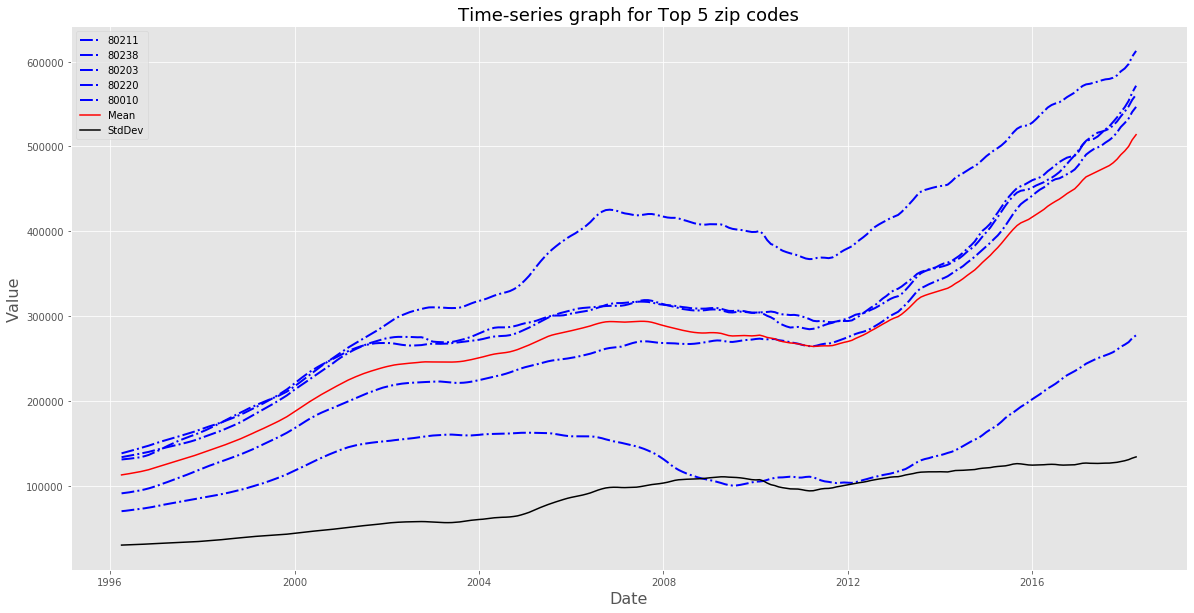

In [18]:
plt.figure(figsize=(20,10))
for z in top5_zip:
    
    plt.plot(dts[dts.RegionName ==z].ts,color='b',lw=2,ls='-.', label= z)
    mean_ = dts.groupby('ds').aggregate({'ts':'mean'})
    std_ = dts.groupby('ds').aggregate({'ts':'std'})

plt.plot(mean_, color= 'red',label= 'Mean')
plt.plot(std_, color= 'black',label= 'StdDev')

# Add title
plt.title('Time-series graph for Top 5 zip codes', fontsize=18)

# Add Labels
plt.xlabel('Date', fontsize=16)
plt.ylabel('Value', fontsize=16)
plt.legend()

# Show graph
plt.show()

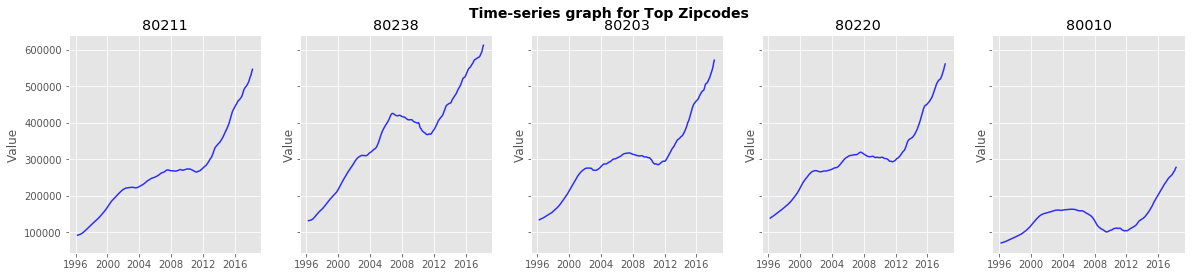

In [19]:
#Plot the individual zip codes
fig, axs = plt.subplots(1,5,figsize=(20,4),sharey=True)
for ax, column, index in zip(axs,top5_zip, range(0,5)):
    ax.plot(dts[dts.RegionName ==column].ts, color='b',alpha=0.8)
    ax.set_title(column)
    ax.set_ylabel('Value')
fig.suptitle('Time-series graph for Top Zipcodes', fontsize=14, fontweight='bold');


There does appear to be an overall increasing trend.  
There appears to be some differences in the variance over time.  
There may be some seasonality (i.e., cycles) in the data.  
Not sure about outliers.  

## Look at stationarity
Most time-series models assume that the underlying time-series data is **stationary**.  This assumption gives us some nice statistical properties that allows us to use various models for forecasting.

**Stationarity** is a statistical assumption that a time-series has:
*   **Constant mean**
*   **Constant variance**
*   **Autocovariance does not depend on time**

If we are using past data to predict future data, we should assume that the data will follow the same general trends and patterns as in the past.  This general statement holds for most training data and modeling tasks.


# Transform the Data

In [20]:
#Perform the rolling statistics (rolling mean & rolling std dev) to check stationarity).  
#Plot the moving average and the moving variance to see if it varies with time. 
#This is a visualize technique of checking the stationarity of the data
from statsmodels.tsa.stattools import adfuller
def test_stationarity(df, ts):

    for z in top5_zip: 
        df = dts[dts.RegionName == z]
       
        # Determing rolling statistics
        rolmean = df[ts].rolling(window = 12, center = False).mean()
        rolstd = df[ts].rolling(window = 12, center = False).std()

        # Plot rolling statistics:
        orig = plt.plot(df[ts], 
                        color = 'blue', 
                        label = 'Original')
        mean = plt.plot(rolmean, 
                        color = 'red', 
                        label = 'Rolling Mean')
        std = plt.plot(rolstd, 
                       color = 'black', 
                       label = 'Rolling Std')
        plt.legend(loc = 'best')
        plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
        plt.xticks(rotation = 45)
        plt.show(block = False)
        plt.close()

    # Perform the Augmented Dickey-Fuller (ADF) statistical test to check stationarity:
    # Null Hypothesis (H_0): time series is not stationary. if pvalue > .05 or ADF Test > Critical Value
    # Alternate Hypothesis (H_1): time series is stationary
        print('Zip: ', z,'Results of Dickey-Fuller Test:')
        dftest = adfuller(df[ts], 
                      autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], 
                         index = ['ADF Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
        for key, value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value

        print(dfoutput)

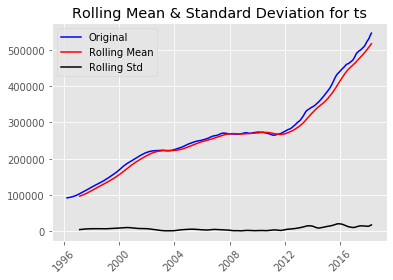

Zip:  80211 Results of Dickey-Fuller Test:
ADF Test Statistic               1.385263
p-value                          0.997046
# Lags Used                     15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


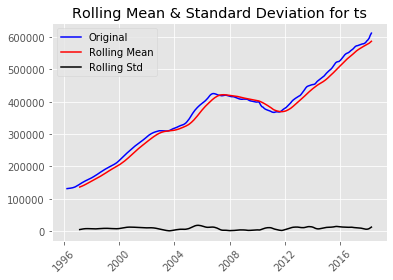

Zip:  80238 Results of Dickey-Fuller Test:
ADF Test Statistic              -0.241269
p-value                          0.933420
# Lags Used                      8.000000
Number of Observations Used    256.000000
Critical Value (1%)             -3.456155
Critical Value (5%)             -2.872897
Critical Value (10%)            -2.572822
dtype: float64


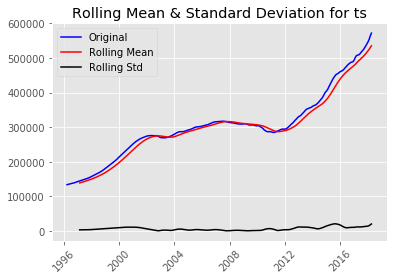

Zip:  80203 Results of Dickey-Fuller Test:
ADF Test Statistic               0.902716
p-value                          0.993126
# Lags Used                     16.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


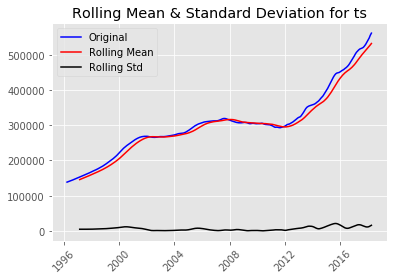

Zip:  80220 Results of Dickey-Fuller Test:
ADF Test Statistic               0.776104
p-value                          0.991240
# Lags Used                     15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


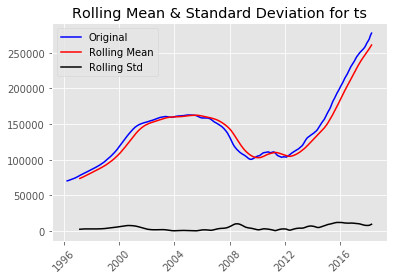

Zip:  80010 Results of Dickey-Fuller Test:
ADF Test Statistic              -0.869156
p-value                          0.797960
# Lags Used                     11.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


In [21]:
#Inspect the plots for visual determination if ts is stationary or not  

test_stationarity(df = dts, ts = 'ts')


**Looking at our data:**
- Rolling mean and standard deviation look like they change over time, hence, are not constant. Based on **Dickey-Fuller test**, the Test Statistics for each zip is greater than all of its critical values and also the the p-values are all greater than .05, we fail to reject the null hypothesis (that the time series is not stationary) at the p = 0.05 level, thus concluding that we fail to reject the null hypothesis that our **time series is not stationary**.  
- We will next transform our data and there maybe some de-trending and removing seasonality involved. 

## Correct for stationarity
When not to use time series analysis
+ Values are constant  
+ Values in the form of functions  

Time series has a particular behavior over time, there is a very high probability that it will follow the same in the future.

How to remove stationarity? Meet these three conditions:    
+ constant mean 
+ constant variance  
+ autocovariance that does not depend in time  



ADCF- Augmented dickey-Fuller Test - Null hypothesis is that the TS is non-stationary.  The test results comprise of test statistic and some critical values for different confidence level.  The test statistic is less than the Critical Value, then we can reject the null hypothesis and say that the series is stationary.  


AR -Auto regressive + MA- moving average   
ARIMA -Integration   
d= order of differentiation  
P = autoregressive lags   
Q= moving average  
predict p - use PACF graph  
predict q - use use ACF  


2 common reasons behind non-stationarity are:

1. **Trend** – mean is not constant over time.
2. **Seasonality** – variance is not constant over time.

There are ways to correct for trend and seasonality, to make the time series stationary.

**What happens if you do not correct for these things?**

- Variance can be mis-specified
- Model fit can be worse.  
- Not leveraging valuable time-dependent nature of the data.  



# Data Transformation

RegionName        ts     ts_log  ts_moving_avg  ts_log_moving_avg  \
ds                                                                             
1996-06-01      80238  132200.0  11.792071  113283.333333          11.607230   
1996-06-01      80203  135700.0  11.818202  116975.000000          11.640164   
1996-06-01      80220  141000.0  11.856515  117783.333333          11.646103   
1996-06-01      80010   71400.0  11.176053  112566.666667          11.593642   
1996-07-01      80211   93400.0  11.444647  108808.333333          11.560810   

            ts_moving_avg_diff  ts_log_moving_avg_diff  ts_log_diff  
ds                                                                   
1996-06-01        18916.666667                0.184841     0.356027  
1996-06-01        18725.000000                0.178038     0.026131  
1996-06-01        23216.666667                0.210412     0.038313  
1996-06-01       -41166.666667               -0.417589    -0.680462  
1996-07-01       -15408.333333               -0.116163     0.268593

Transformation - log ts


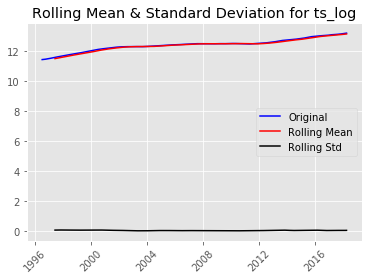

Zip:  80211 Results of Dickey-Fuller Test:
ADF Test Statistic              -0.115368
p-value                          0.947886
# Lags Used                     10.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


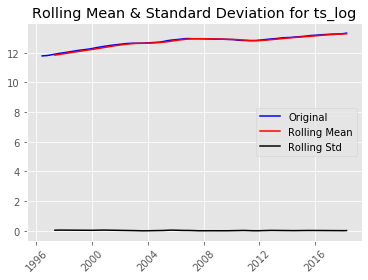

Zip:  80238 Results of Dickey-Fuller Test:
ADF Test Statistic              -1.407387
p-value                          0.578730
# Lags Used                      8.000000
Number of Observations Used    254.000000
Critical Value (1%)             -3.456360
Critical Value (5%)             -2.872987
Critical Value (10%)            -2.572870
dtype: float64


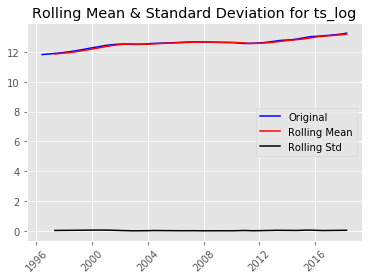

Zip:  80203 Results of Dickey-Fuller Test:
ADF Test Statistic              -0.613863
p-value                          0.867819
# Lags Used                     16.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


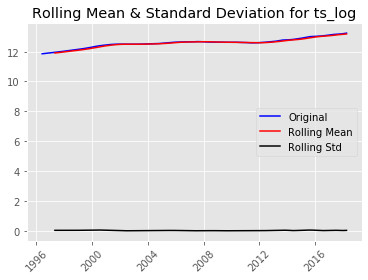

Zip:  80220 Results of Dickey-Fuller Test:
ADF Test Statistic              -0.365563
p-value                          0.915692
# Lags Used                     15.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


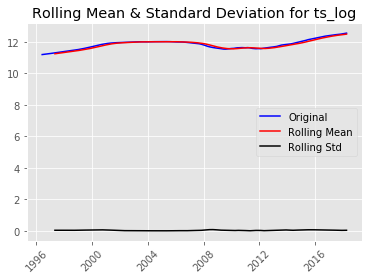

Zip:  80010 Results of Dickey-Fuller Test:
ADF Test Statistic              -1.275132
p-value                          0.640471
# Lags Used                     11.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


Transformation - 12-month moving averages of log ts


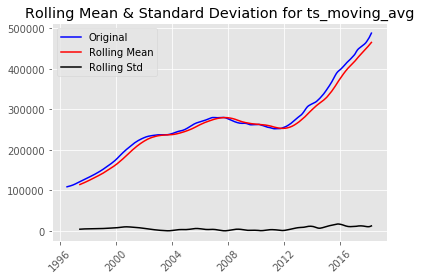

Zip:  80211 Results of Dickey-Fuller Test:
ADF Test Statistic               1.399867
p-value                          0.997114
# Lags Used                     16.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


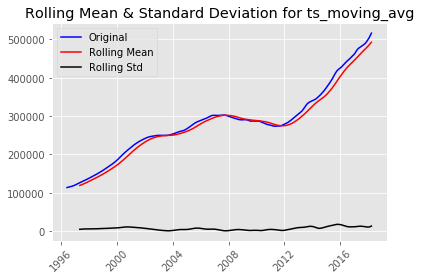

Zip:  80238 Results of Dickey-Fuller Test:
ADF Test Statistic               1.304931
p-value                          0.996636
# Lags Used                     16.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


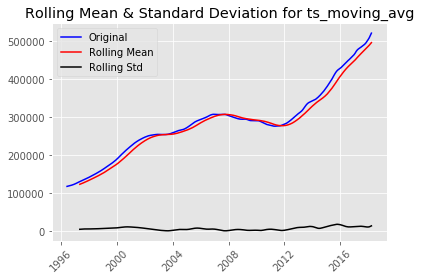

Zip:  80203 Results of Dickey-Fuller Test:
ADF Test Statistic               1.027630
p-value                          0.994549
# Lags Used                     14.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


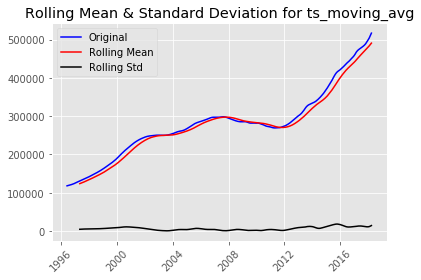

Zip:  80220 Results of Dickey-Fuller Test:
ADF Test Statistic               1.100952
p-value                          0.995225
# Lags Used                     12.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


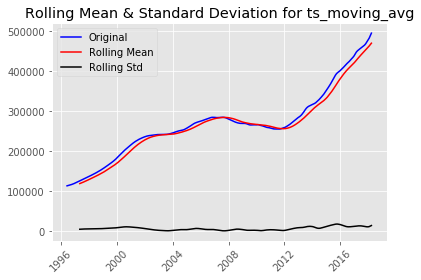

Zip:  80010 Results of Dickey-Fuller Test:
ADF Test Statistic               0.840898
p-value                          0.992268
# Lags Used                     16.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


Transformation - Difference between logged ts and logged moving average ts


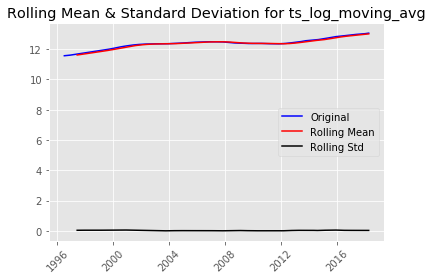

Zip:  80211 Results of Dickey-Fuller Test:
ADF Test Statistic              -0.005413
p-value                          0.958082
# Lags Used                     16.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


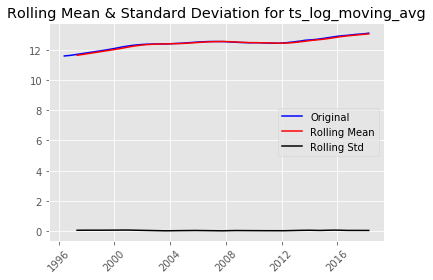

Zip:  80238 Results of Dickey-Fuller Test:
ADF Test Statistic               0.038816
p-value                          0.961627
# Lags Used                     12.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


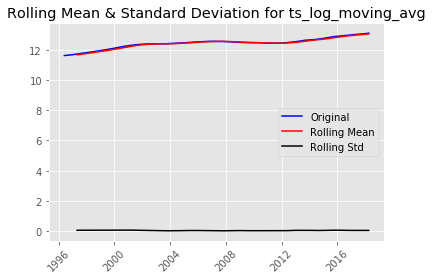

Zip:  80203 Results of Dickey-Fuller Test:
ADF Test Statistic              -0.149613
p-value                          0.944267
# Lags Used                     12.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


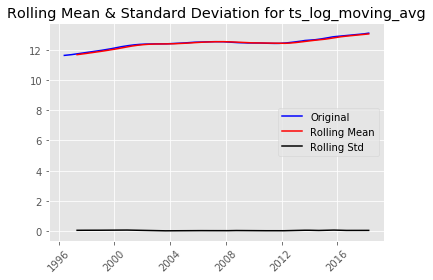

Zip:  80220 Results of Dickey-Fuller Test:
ADF Test Statistic              -0.297242
p-value                          0.925894
# Lags Used                     15.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


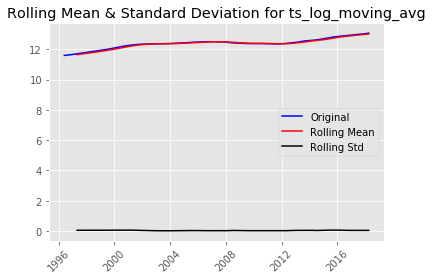

Zip:  80010 Results of Dickey-Fuller Test:
ADF Test Statistic              -0.460615
p-value                          0.899476
# Lags Used                     12.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


Transformation - Difference between ts and moving average ts


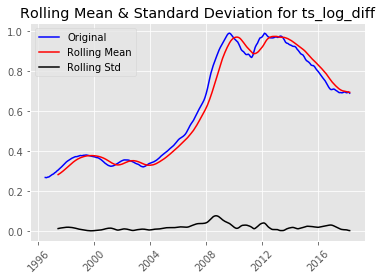

Zip:  80211 Results of Dickey-Fuller Test:
ADF Test Statistic              -1.437371
p-value                          0.564235
# Lags Used                     12.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


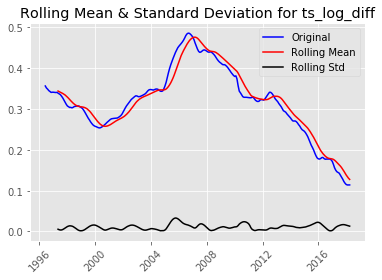

Zip:  80238 Results of Dickey-Fuller Test:
ADF Test Statistic              -1.007140
p-value                          0.750651
# Lags Used                     13.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


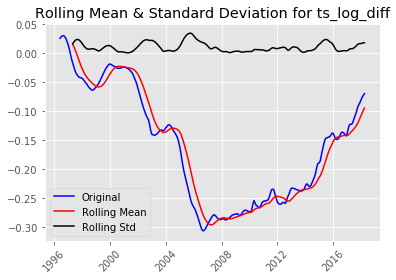

Zip:  80203 Results of Dickey-Fuller Test:
ADF Test Statistic              -1.267243
p-value                          0.644022
# Lags Used                     14.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


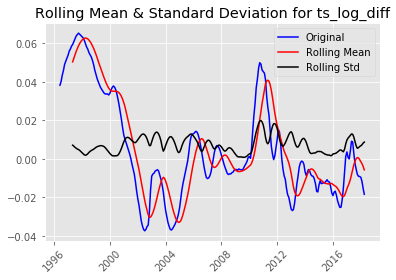

Zip:  80220 Results of Dickey-Fuller Test:
ADF Test Statistic              -2.851142
p-value                          0.051332
# Lags Used                     16.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


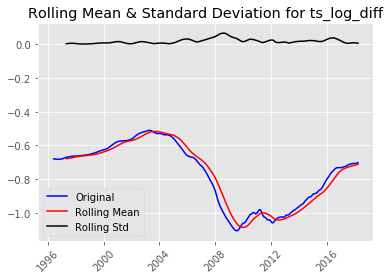

Zip:  80010 Results of Dickey-Fuller Test:
ADF Test Statistic              -1.714659
p-value                          0.423576
# Lags Used                     13.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


Transformation - Difference between ts and moving average ts


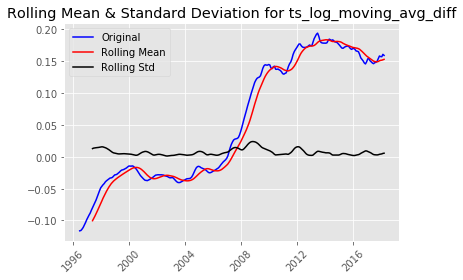

Zip:  80211 Results of Dickey-Fuller Test:
ADF Test Statistic              -1.125513
p-value                          0.704791
# Lags Used                     11.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


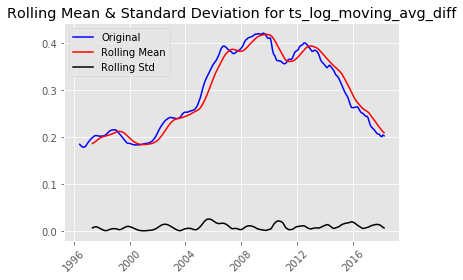

Zip:  80238 Results of Dickey-Fuller Test:
ADF Test Statistic              -1.315847
p-value                          0.621891
# Lags Used                     15.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


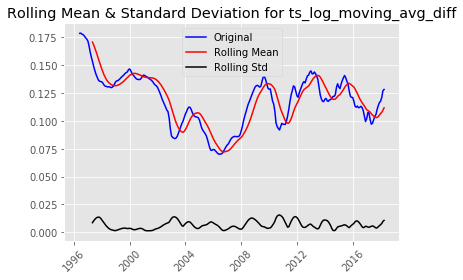

Zip:  80203 Results of Dickey-Fuller Test:
ADF Test Statistic              -2.276985
p-value                          0.179498
# Lags Used                     16.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


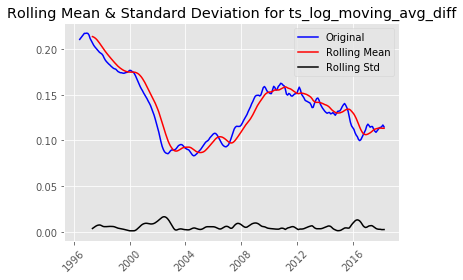

Zip:  80220 Results of Dickey-Fuller Test:
ADF Test Statistic              -2.160002
p-value                          0.221081
# Lags Used                     16.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


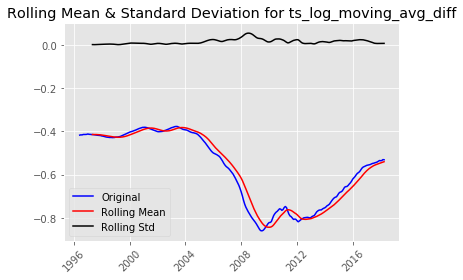

Zip:  80010 Results of Dickey-Fuller Test:
ADF Test Statistic              -1.369411
p-value                          0.596850
# Lags Used                     10.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


In [22]:

# Transformation - log ts
dts['ts_log'] = dts['ts'].apply(lambda x: np.log(x))

# Transformation - 12-month moving averages ts
dts['ts_moving_avg'] = dts['ts'].rolling(window = 12, center = False).mean()

# Transformation - 12-month moving averages of log ts
dts['ts_log_moving_avg'] = dts['ts_log'].rolling(window = 12, center = False).mean()

# Transformation - Difference between ts and moving average ts
dts['ts_moving_avg_diff'] = dts['ts'] - dts['ts_moving_avg']

# Transformation - Difference between logged ts and logged moving average ts
dts['ts_log_moving_avg_diff'] = dts['ts_log'] - dts['ts_log_moving_avg']


# Transformation - Difference between logged ts and logged moving average ts
dts_transform = dts.dropna()


# Transformation - Difference between logged ts and first-order difference logged ts
dts['ts_log_diff'] = dts['ts_log'] - dts['ts_log'].shift()

dts_transform = dts
dts_transform.dropna(inplace=True)


# Display data
display(dts_transform.head())

print('Transformation - log ts')
test_stationarity(df = dts_transform, ts = 'ts_log')
print('\n')
print('Transformation - 12-month moving averages of log ts')
test_stationarity(df = dts_transform, ts = 'ts_moving_avg')
print('\n')
print('Transformation - Difference between logged ts and logged moving average ts')
test_stationarity(df = dts_transform, ts = 'ts_log_moving_avg')
print('\n')
print('Transformation - Difference between ts and moving average ts')
test_stationarity(df = dts_transform, ts = 'ts_log_diff')
print('\n')
print('Transformation - Difference between ts and moving average ts')
test_stationarity(df = dts_transform, ts = 'ts_log_moving_avg_diff')



In [23]:
#Other zip code timeseries have weak stationarity. 
#Only Zip =80521 has a p-value that is less than the significance level
0.027028 < .05

True

## Methods for Eliminating trend and seasonality
*   **Transformation**
  *   *Examples.* Log, square root, etc.
  *   We are going to look at log.
*   **Smoothing**
  *  *Examples.* Weekly average, monthly average, rolling averages.
  *   We are going to look at weekly average.
*   **Differencing**
  *  *Examples.* First-order differencing.
  *   We are going to look at second-order differencing.
*   **Polynomial Fitting**
  *  *Examples.* Fit a regression model.
*   **Decomposition**



In [24]:
def plot_decomposition(df, ts, trend, seasonal, residual):
    
    for z in top5_zip: 
        
        df = dts_transform[dts_transform.RegionName == z]
        print('Zip: ', z,'Decomposition Plots:')
        f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (15, 5), sharex = True)

        ax1.plot(df[ts], label = 'Original')
        ax1.legend(loc = 'best')
        ax1.tick_params(axis = 'x', rotation = 45)

        ax2.plot(df[trend], label = 'Trend')
        ax2.legend(loc = 'best')
        ax2.tick_params(axis = 'x', rotation = 45)

        ax3.plot(df[seasonal],label = 'Seasonality')
        ax3.legend(loc = 'best')
        ax3.tick_params(axis = 'x', rotation = 45)

        ax4.plot(df[residual], label = 'Residuals')
        ax4.legend(loc = 'best')
        ax4.tick_params(axis = 'x', rotation = 45)
        plt.tight_layout()

      # Show graph
        plt.suptitle('Trend, Seasonal, and Residual Decomposition of %s' %(ts), 
                   x = 0.5, 
                   y = 1.05, 
                   fontsize = 18)
        plt.show()
        plt.close()

    return

In [25]:
#Plot the moving average and the moving variance to visualize stationarity of the transformed data

def transformed_stationarity(df, ts):
    """
    Test stationarity using moving average statistics and Dickey-Fuller test
    Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    """
    for z in top5_zip: 
        df = dts_transform[dts_transform.RegionName == z]
       
        # Determing rolling statistics
        rolmean = df[ts].rolling(window = 12, center = False).mean()
        rolstd = df[ts].rolling(window = 12, center = False).std()

        # Plot rolling statistics:
        orig = plt.plot(df[ts], 
                        color = 'blue', 
                        label = 'Original')
        mean = plt.plot(rolmean, 
                        color = 'red', 
                        label = 'Rolling Mean')
        std = plt.plot(rolstd, 
                       color = 'black', 
                       label = 'Rolling Std')
        plt.legend(loc = 'best')
        plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
        plt.xticks(rotation = 45)
        plt.show(block = False)
        plt.close()

    # Perform the Augmented Dickey-Fuller (ADF) statistical test to check stationarity:
    # Null Hypothesis (H_0): time series is not stationary. if pvalue > .05 or ADF Test > Critical Value
    # Alternate Hypothesis (H_1): time series is stationary
        print('Zip: ', z,'Results of Dickey-Fuller Test:')
        dftest = adfuller(df[ts], 
                      autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], 
                         index = ['ADF Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
        for key, value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value

        print(dfoutput)

Zip:  80211 Decomposition Plots:


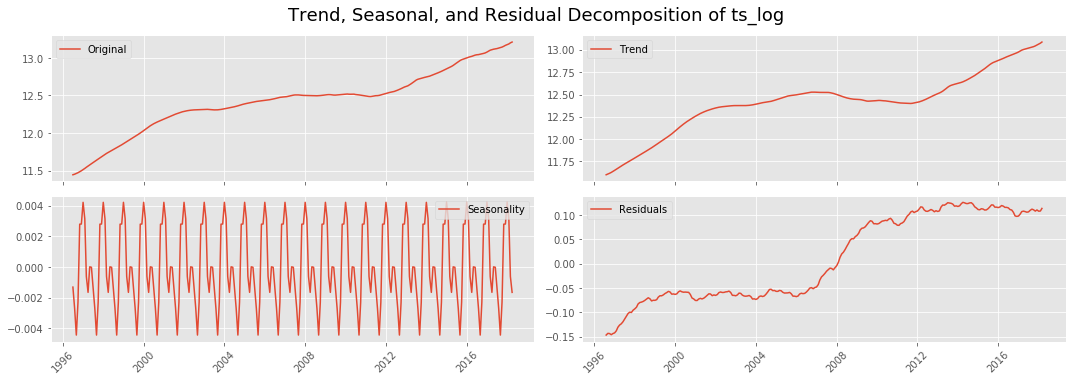

Zip:  80238 Decomposition Plots:


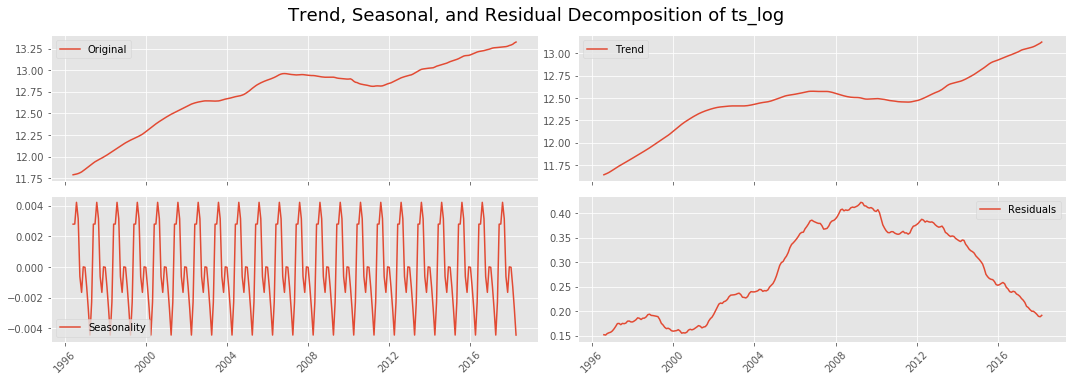

Zip:  80203 Decomposition Plots:


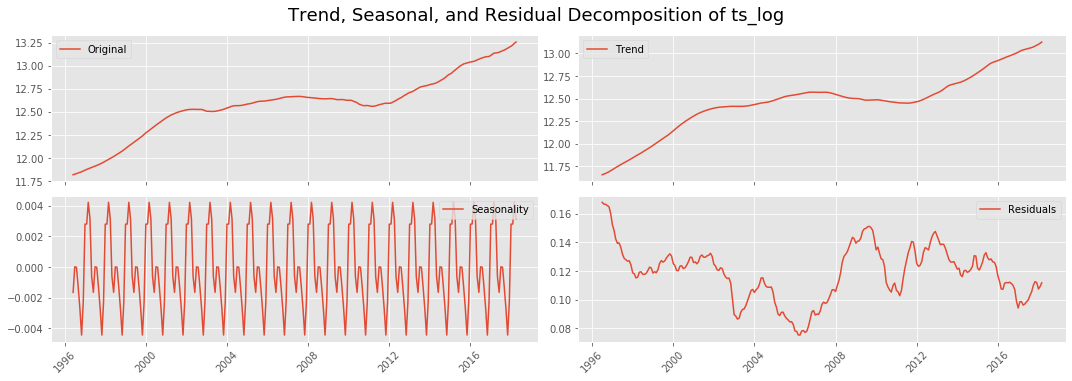

Zip:  80220 Decomposition Plots:


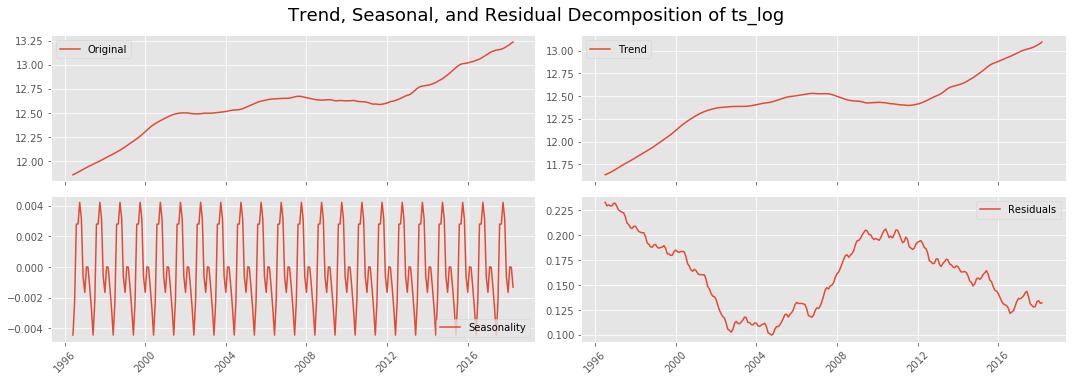

Zip:  80010 Decomposition Plots:


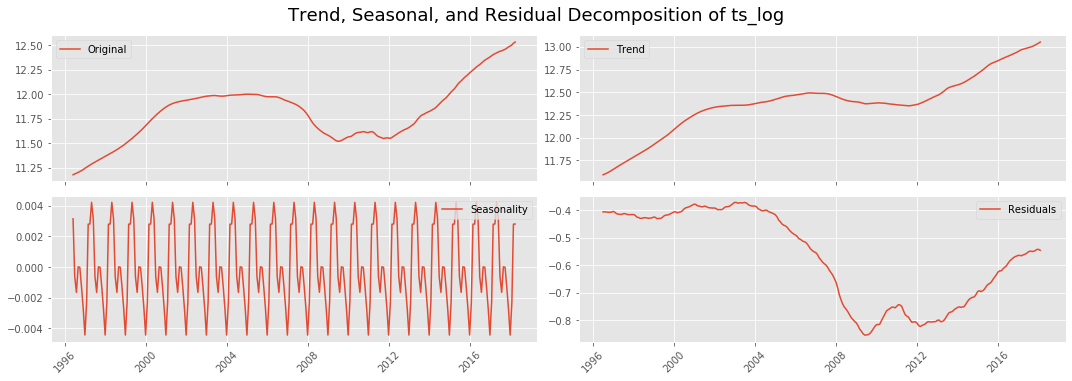

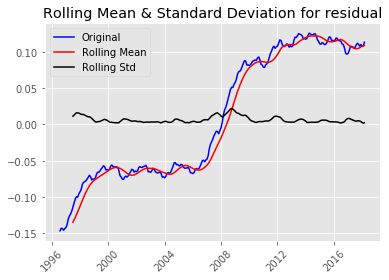

Zip:  80211 Results of Dickey-Fuller Test:
ADF Test Statistic              -0.629741
p-value                          0.864119
# Lags Used                     16.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64


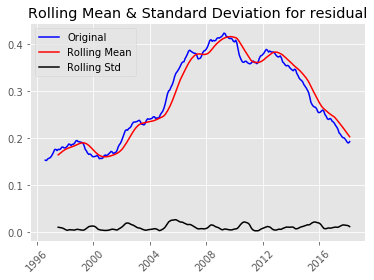

Zip:  80238 Results of Dickey-Fuller Test:
ADF Test Statistic              -1.370352
p-value                          0.596404
# Lags Used                     15.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64


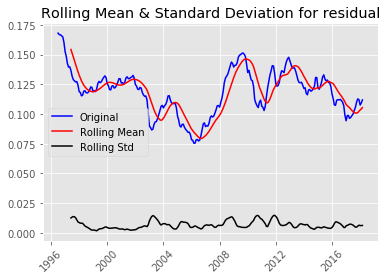

Zip:  80203 Results of Dickey-Fuller Test:
ADF Test Statistic              -2.687654
p-value                          0.076199
# Lags Used                     16.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64


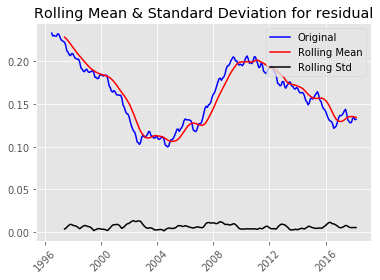

Zip:  80220 Results of Dickey-Fuller Test:
ADF Test Statistic              -2.131356
p-value                          0.232094
# Lags Used                     16.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64


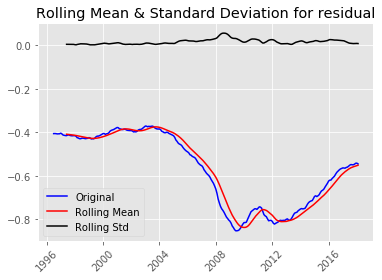

Zip:  80010 Results of Dickey-Fuller Test:
ADF Test Statistic              -1.414705
p-value                          0.575207
# Lags Used                     16.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64


In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(dts_transform['ts_log'], freq = 12)

dts_transform.loc[:,'trend'] = decomposition.trend
dts_transform.loc[:,'seasonal'] = decomposition.seasonal
dts_transform.loc[:,'residual'] = decomposition.resid

plot_decomposition(df = dts_transform, 
                   ts = 'ts_log', 
                   trend = 'trend',
                   seasonal = 'seasonal', 
                   residual = 'residual');
dts_transform = dts_transform.dropna()
transformed_stationarity(df = dts_transform, ts = 'residual')


There is a trend in our time series and seasonality.  The residuals are NOT stationary. Let's perform some differencing since the series is non-stationary and then visualize the auto-correlation plot


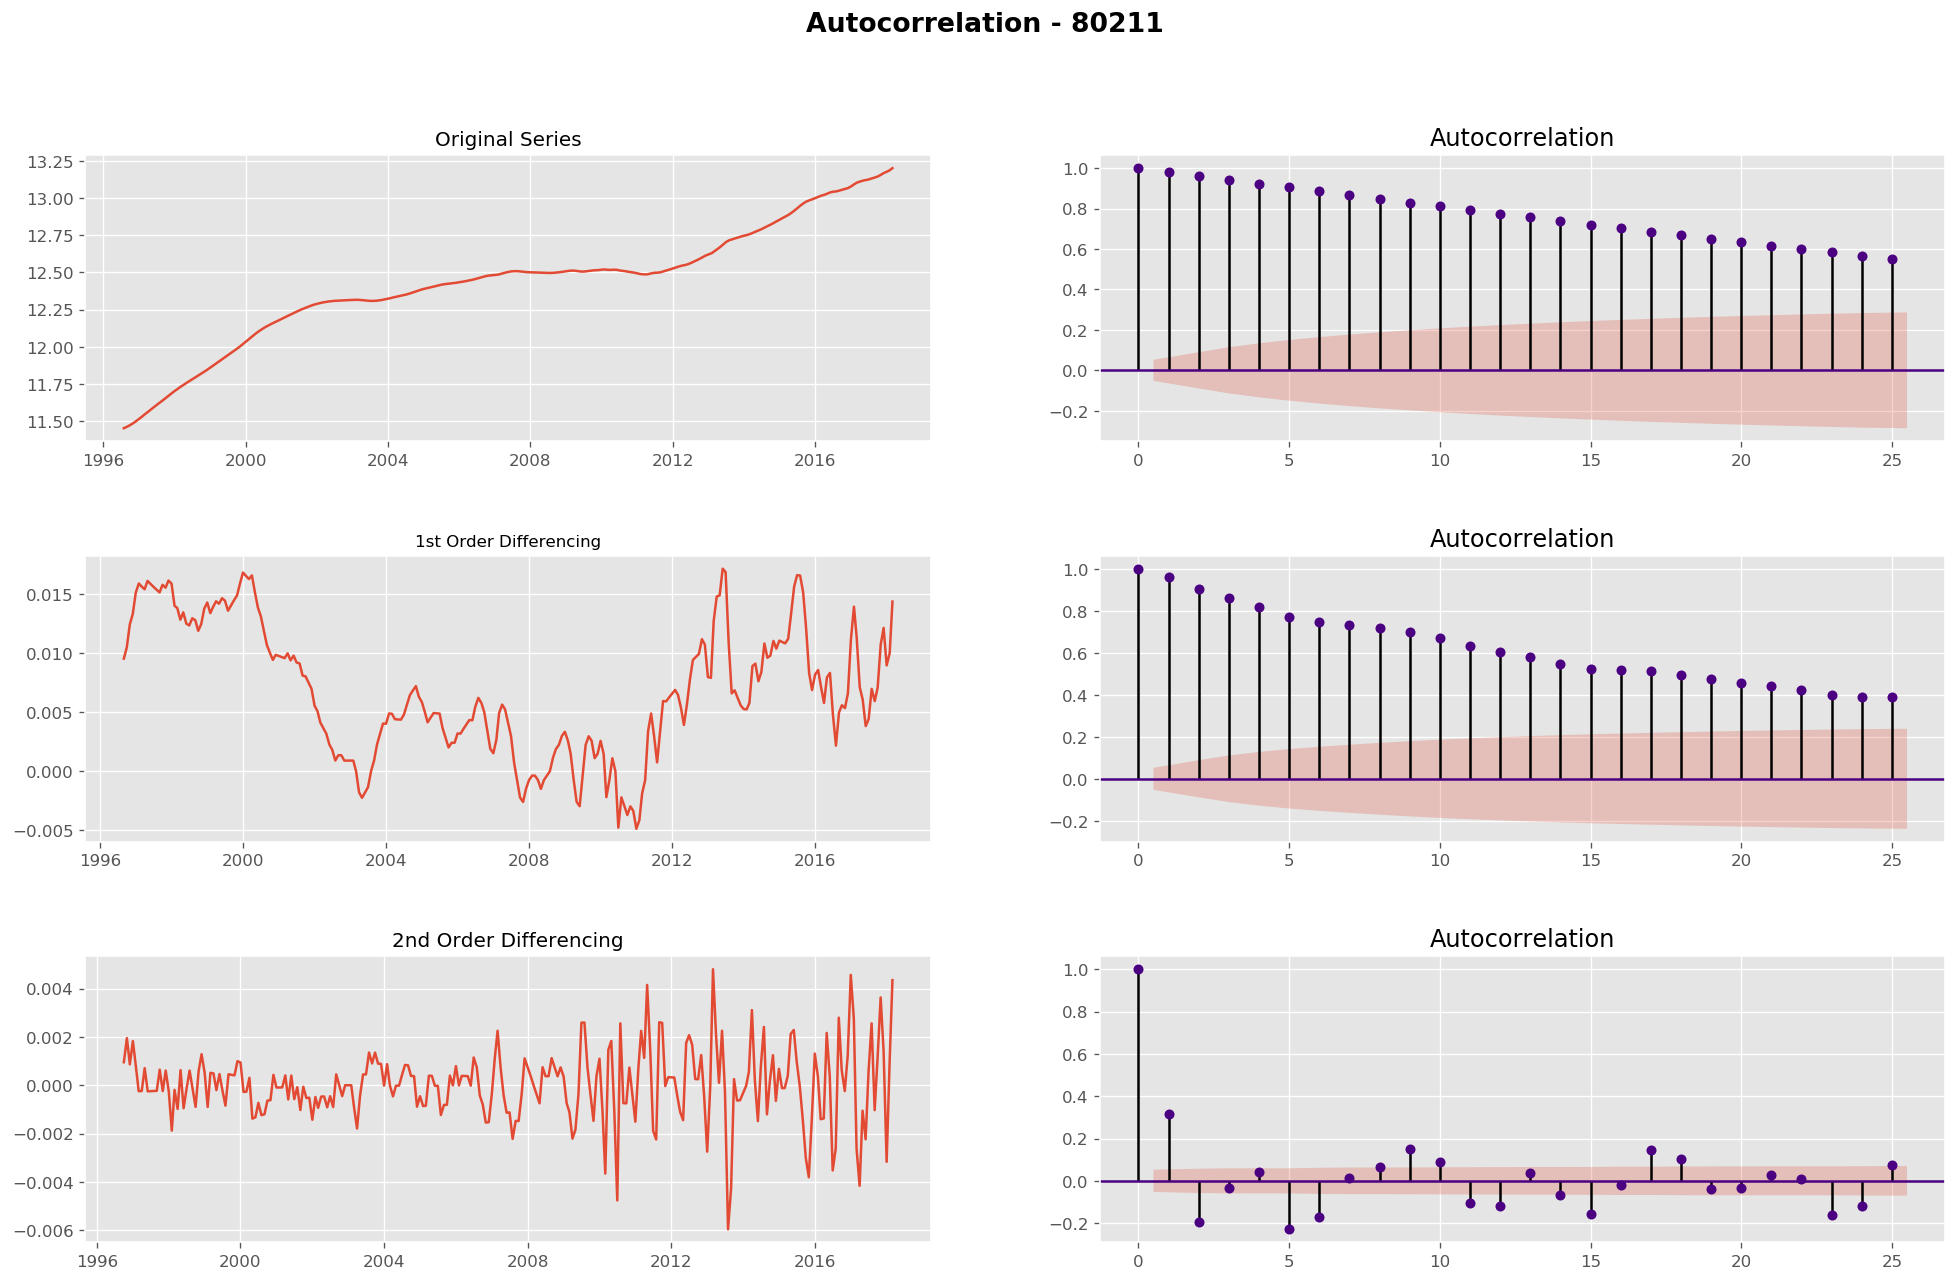

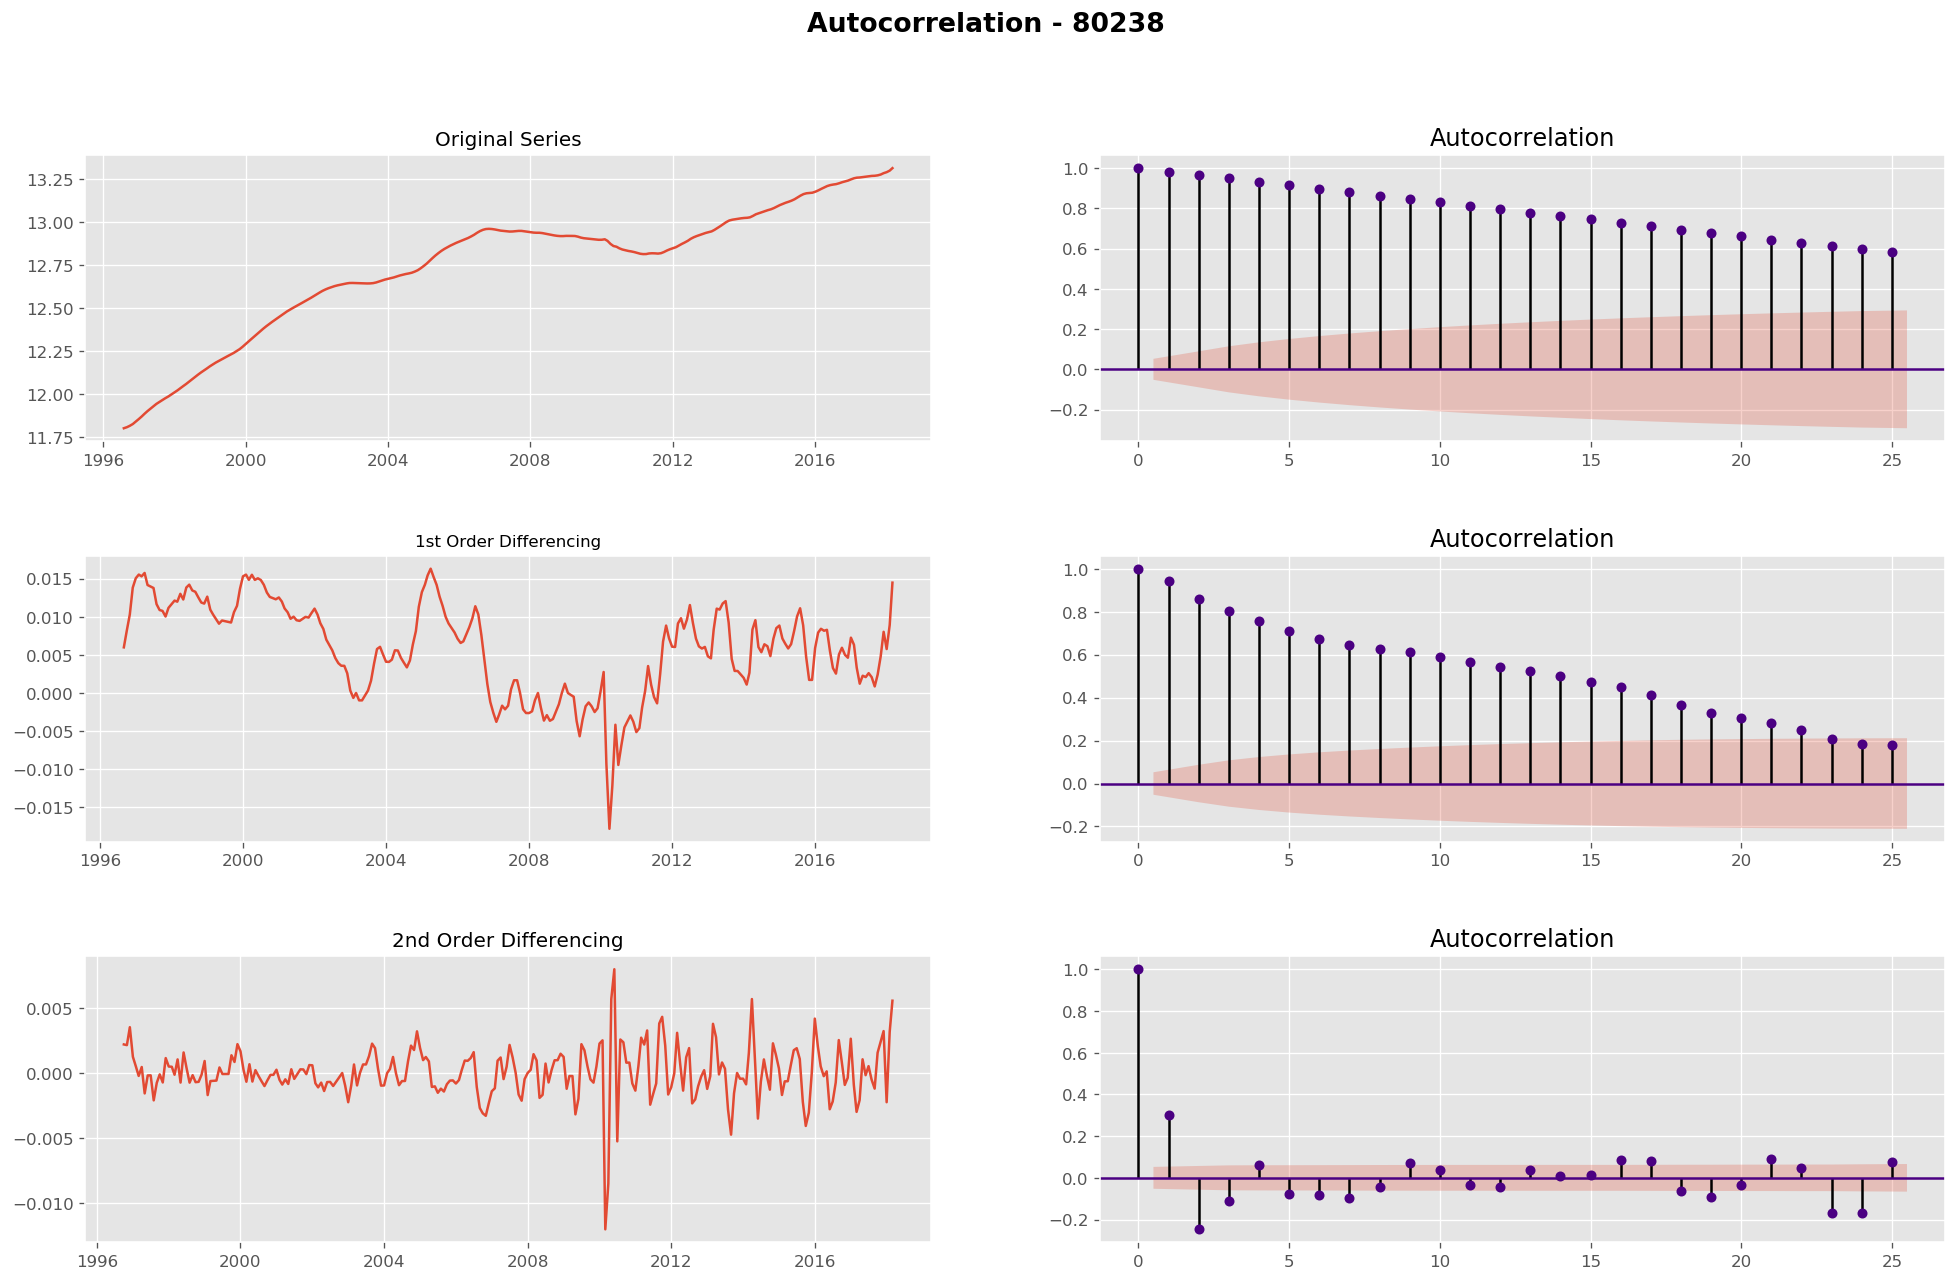

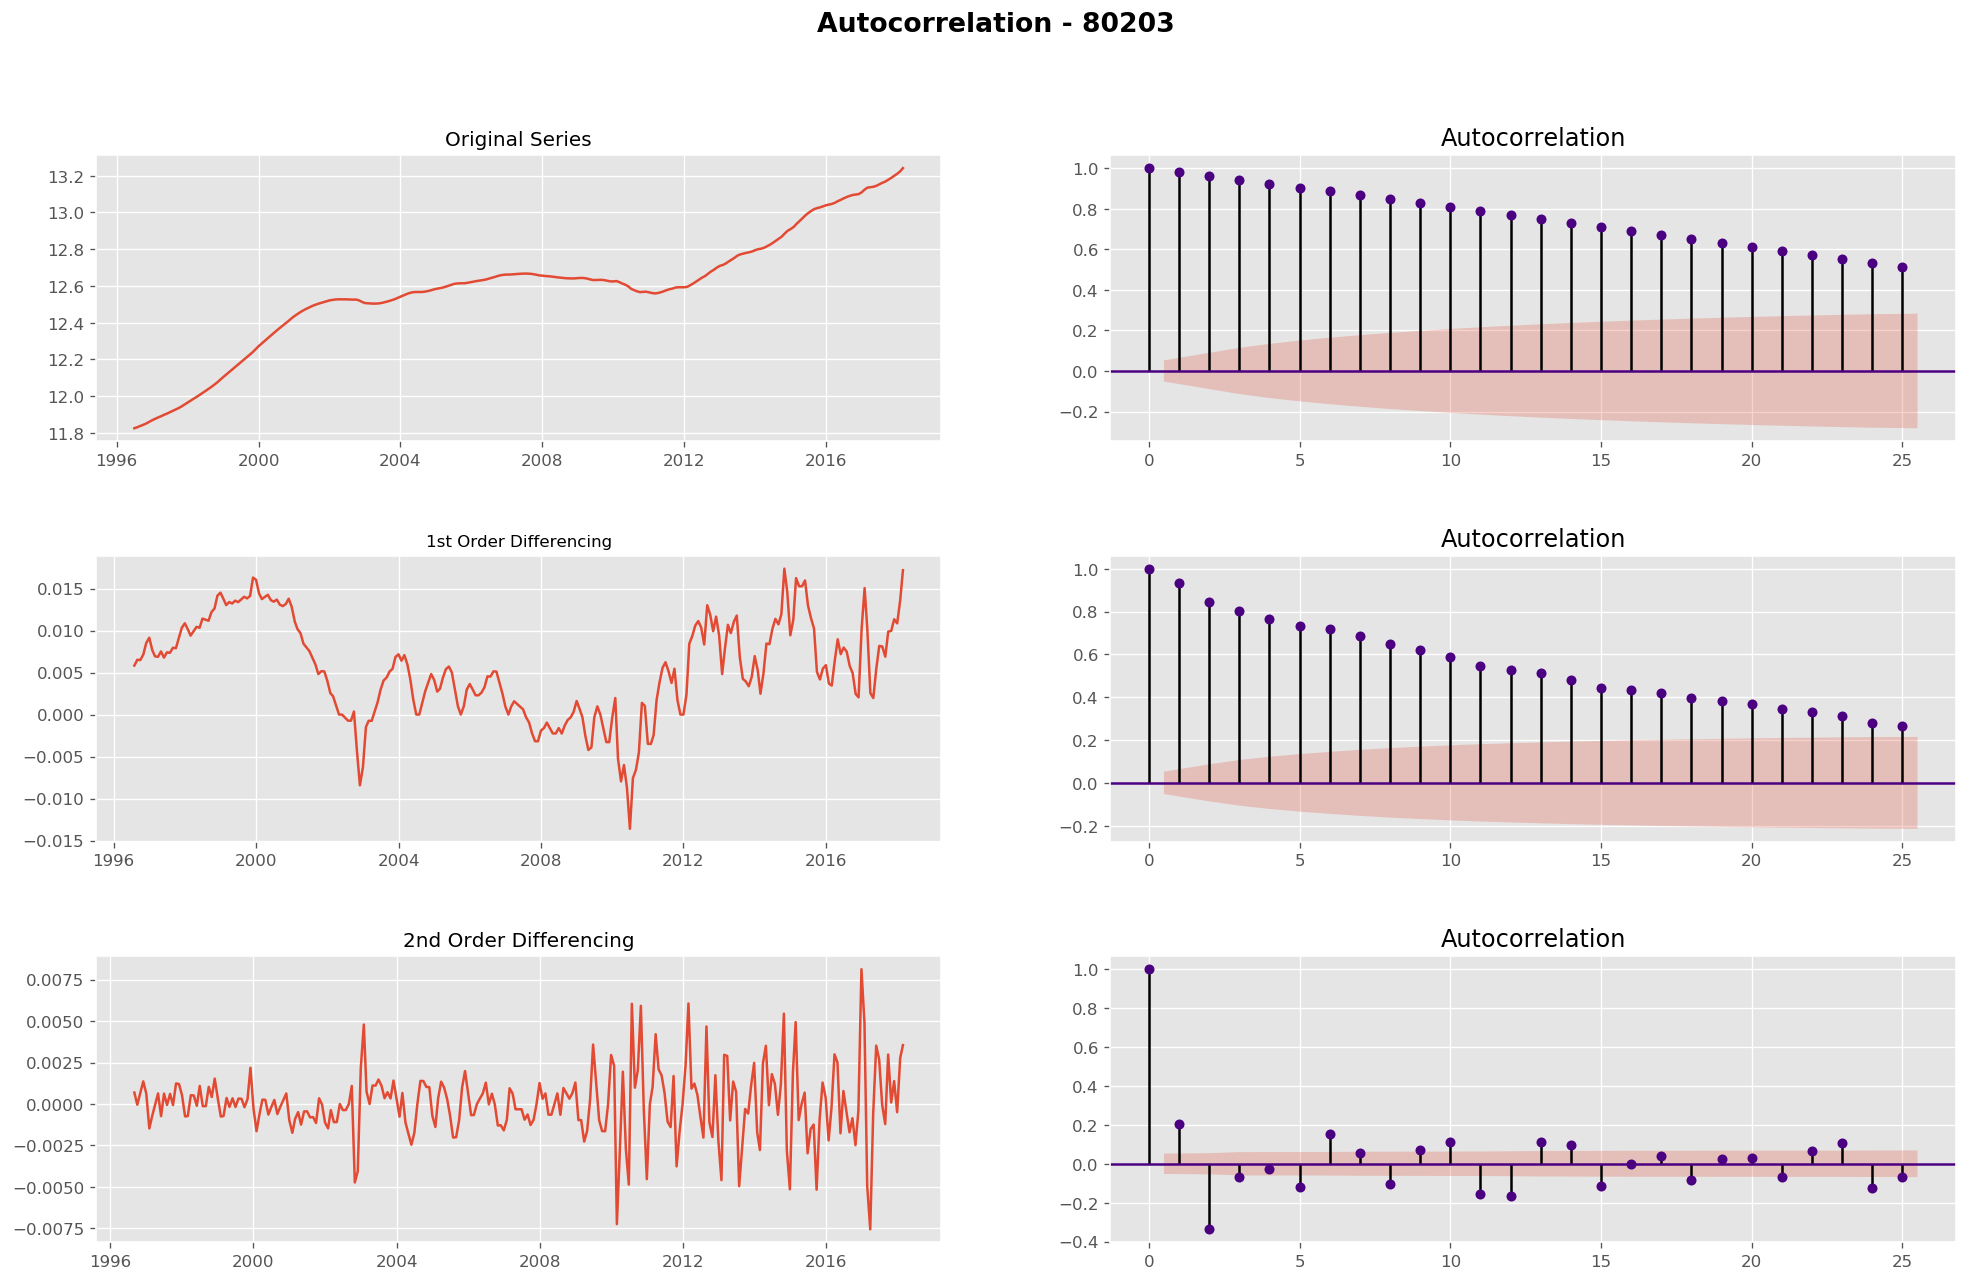

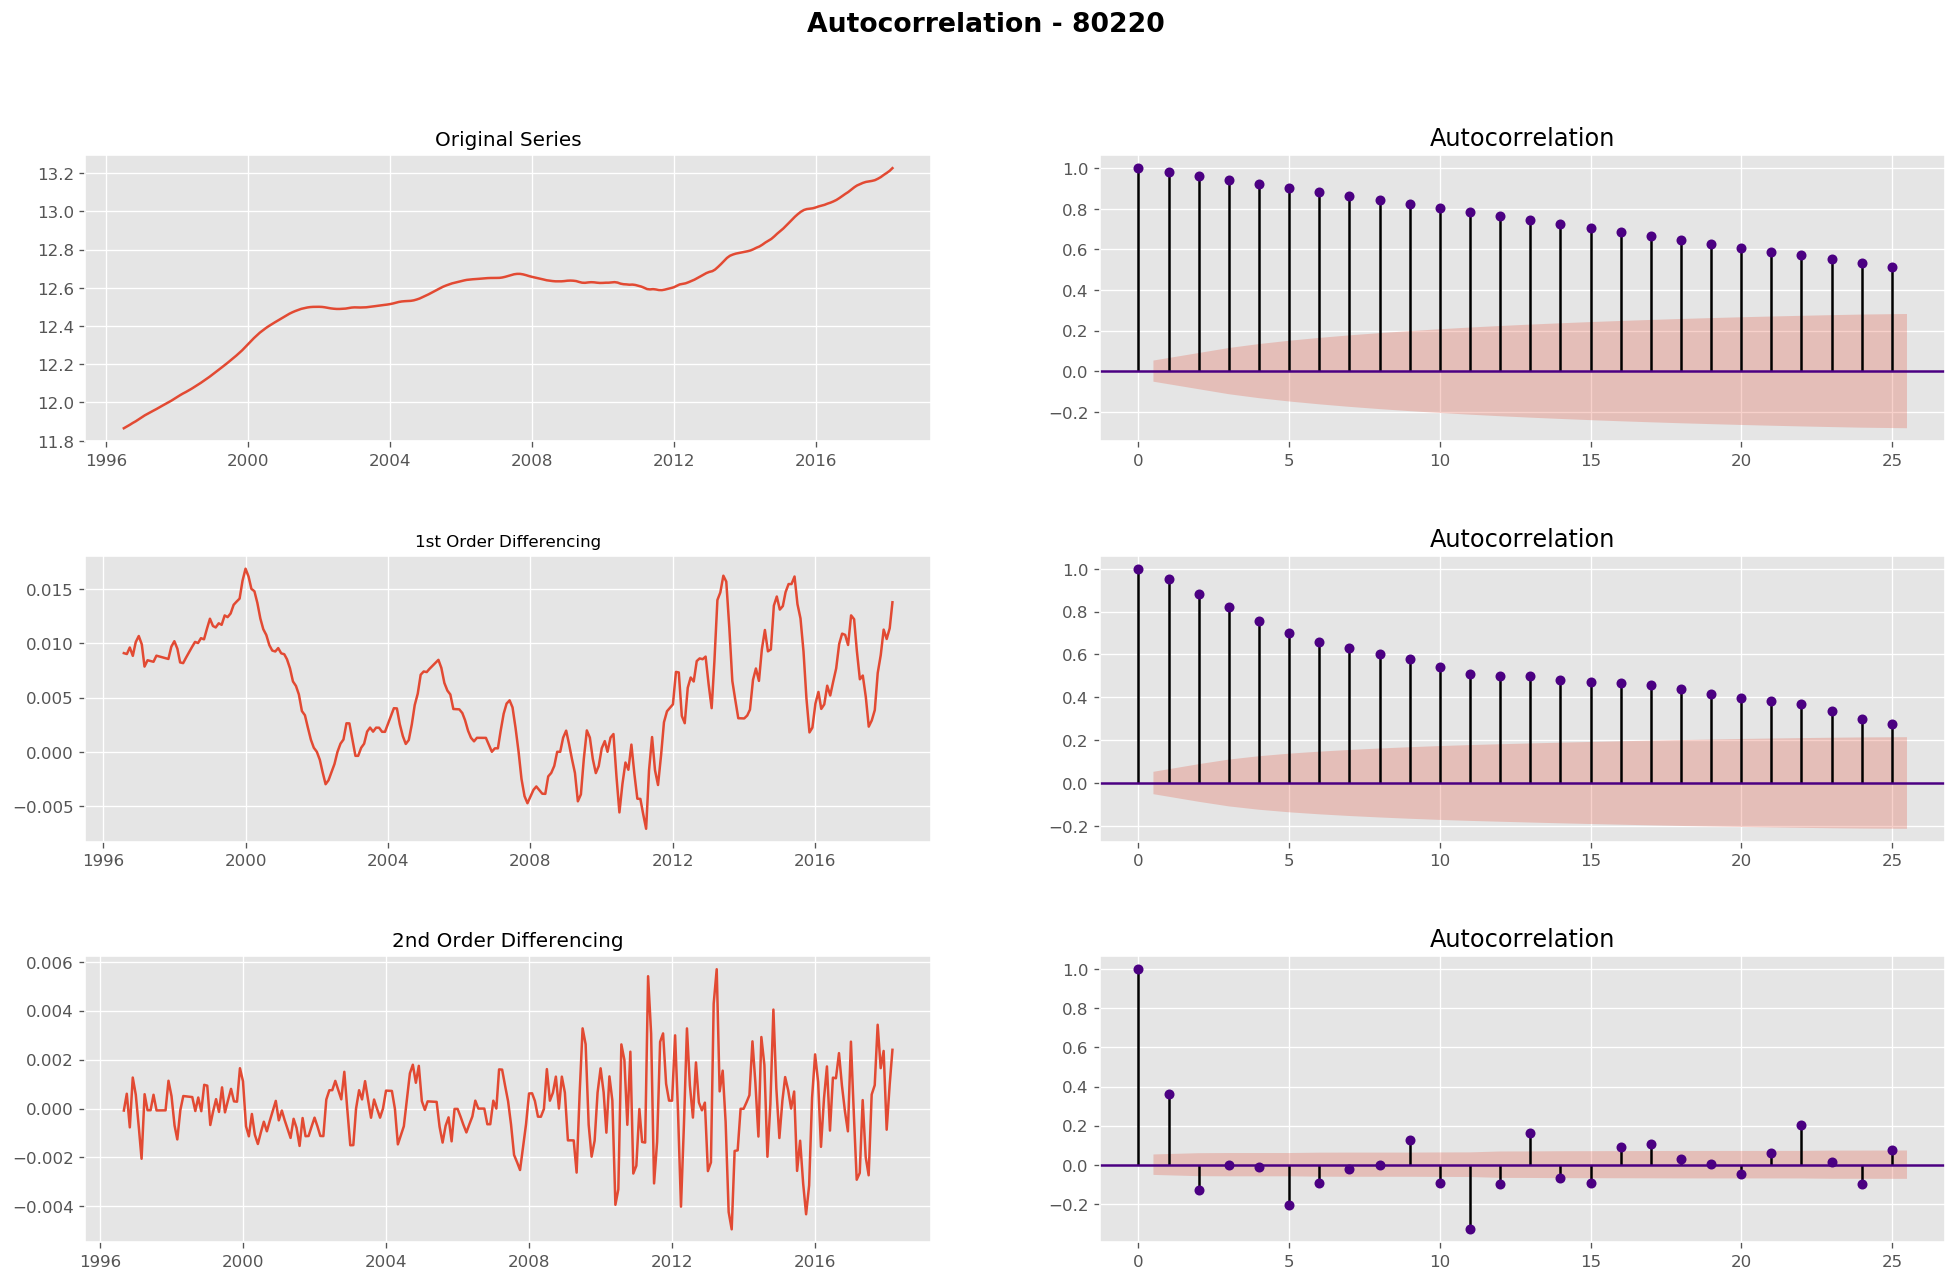

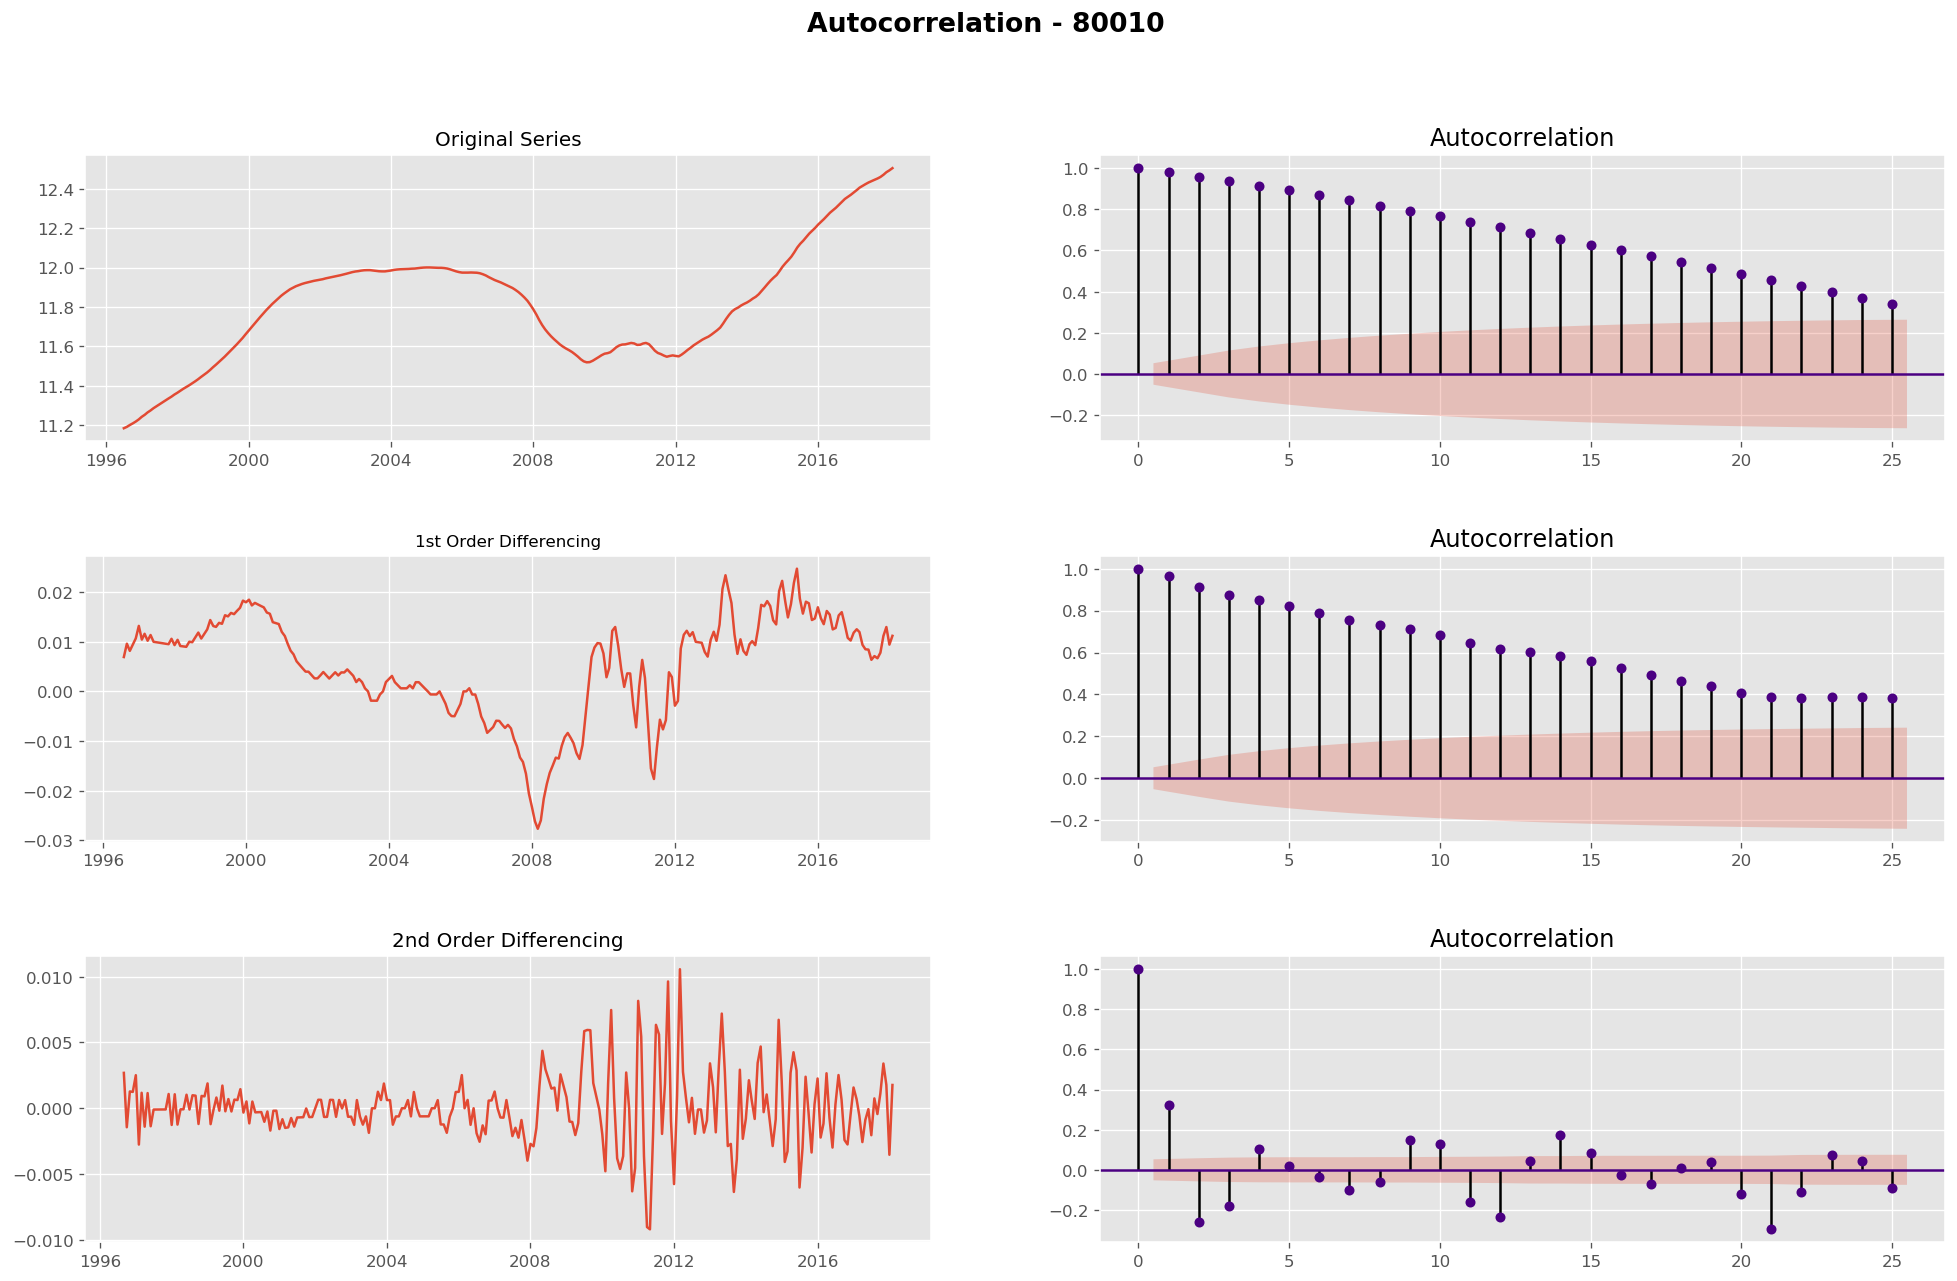

In [27]:
#https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
# check ACF and PACF  
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams
plt.rcParams.update({'figure.figsize':(20,12), 'figure.dpi':120})

for z in top5_zip: 
    dts_corr = dts_transform[dts_transform.RegionName == z]
    
# Original Series
    fig, axes = plt.subplots(3, 2)
    axes[0, 0].plot(dts_corr.ts_log); axes[0, 0].set_title('Original Series',fontsize=12)
    plot_acf(dts_corr.ts_log, ax=axes[0, 1], color='indigo',alpha=0.4)

    # 1st Differencing
    axes[1, 0].plot(dts_corr.ts_log.diff()); axes[1, 0].set_title('1st Order Differencing',fontsize=10)
    plot_acf(dts_corr.ts_log.diff().dropna(), ax=axes[1, 1], color='indigo',alpha=0.4)

    # 2nd Differencing
    axes[2, 0].plot(dts_corr.ts_log.diff().diff()); axes[2, 0].set_title('2nd Order Differencing',fontsize=12)
    plot_acf(dts_corr.ts_log.diff().diff().dropna(), color='indigo',alpha=0.4, ax=axes[2, 1])

    fig.suptitle('Autocorrelation - ' + str(z), fontsize=16, fontweight='bold')
    plt.subplots_adjust(hspace = 0.4 )
    plt.show()


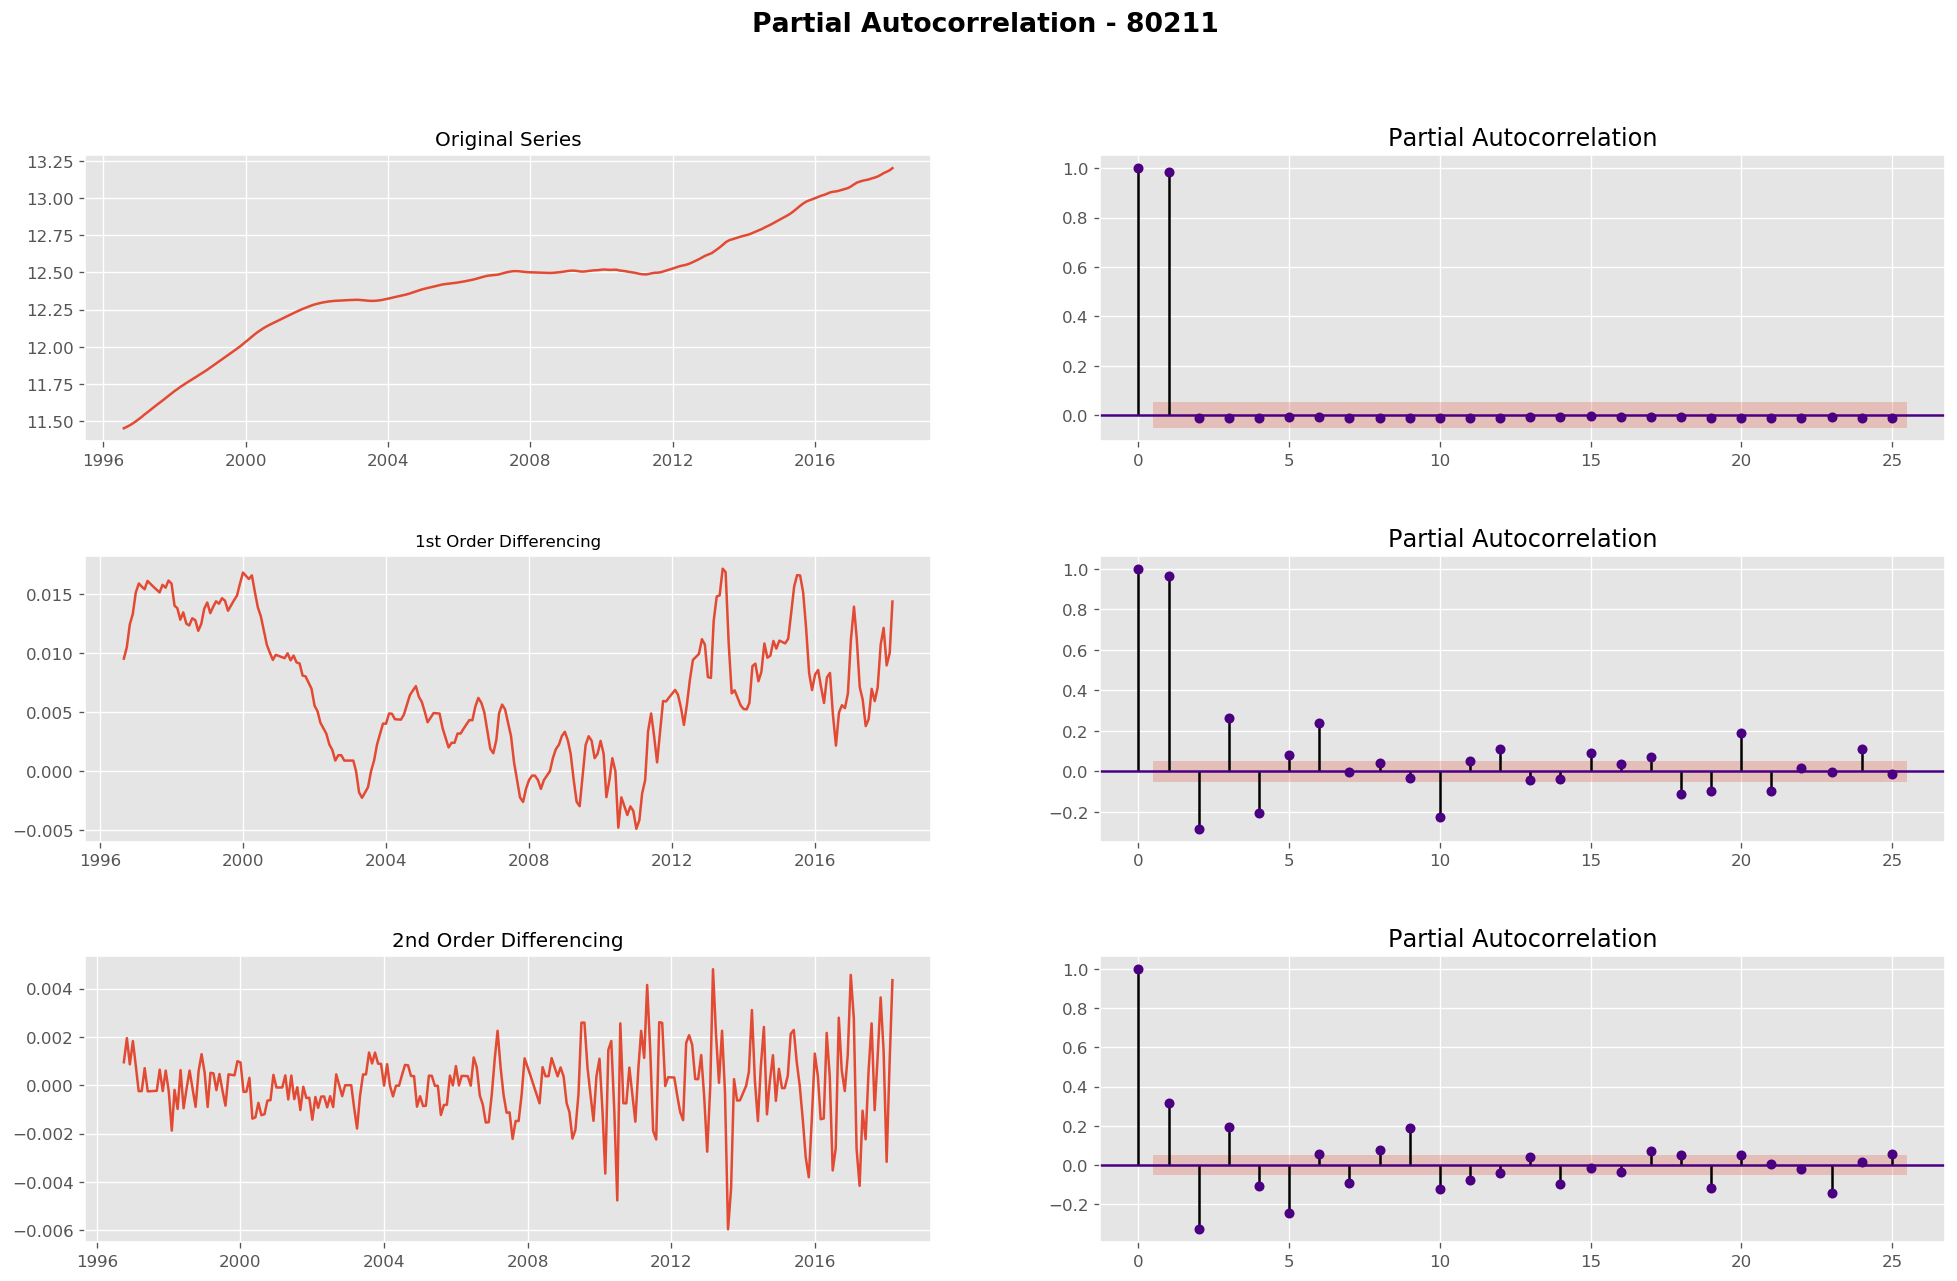

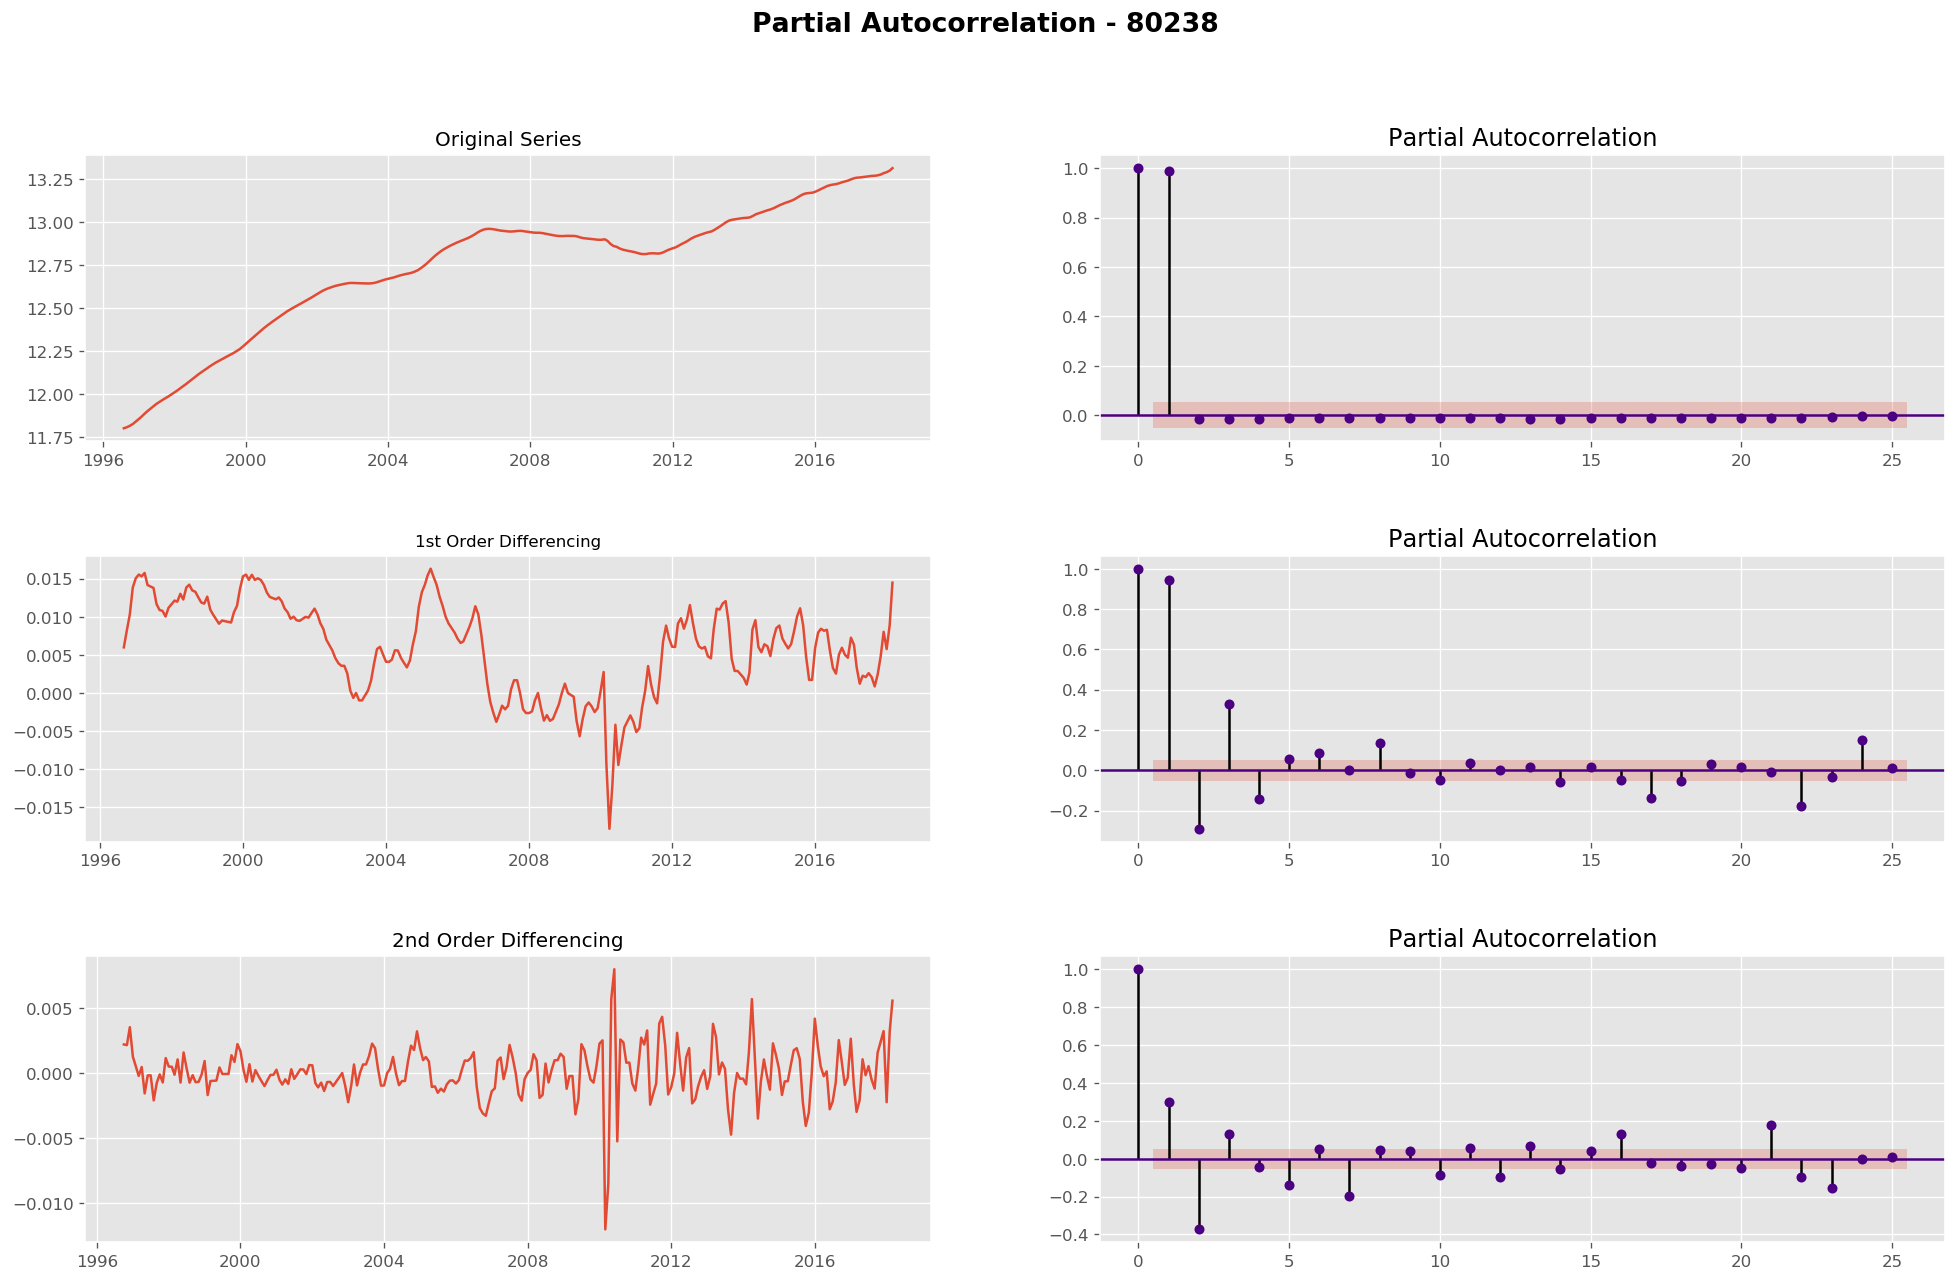

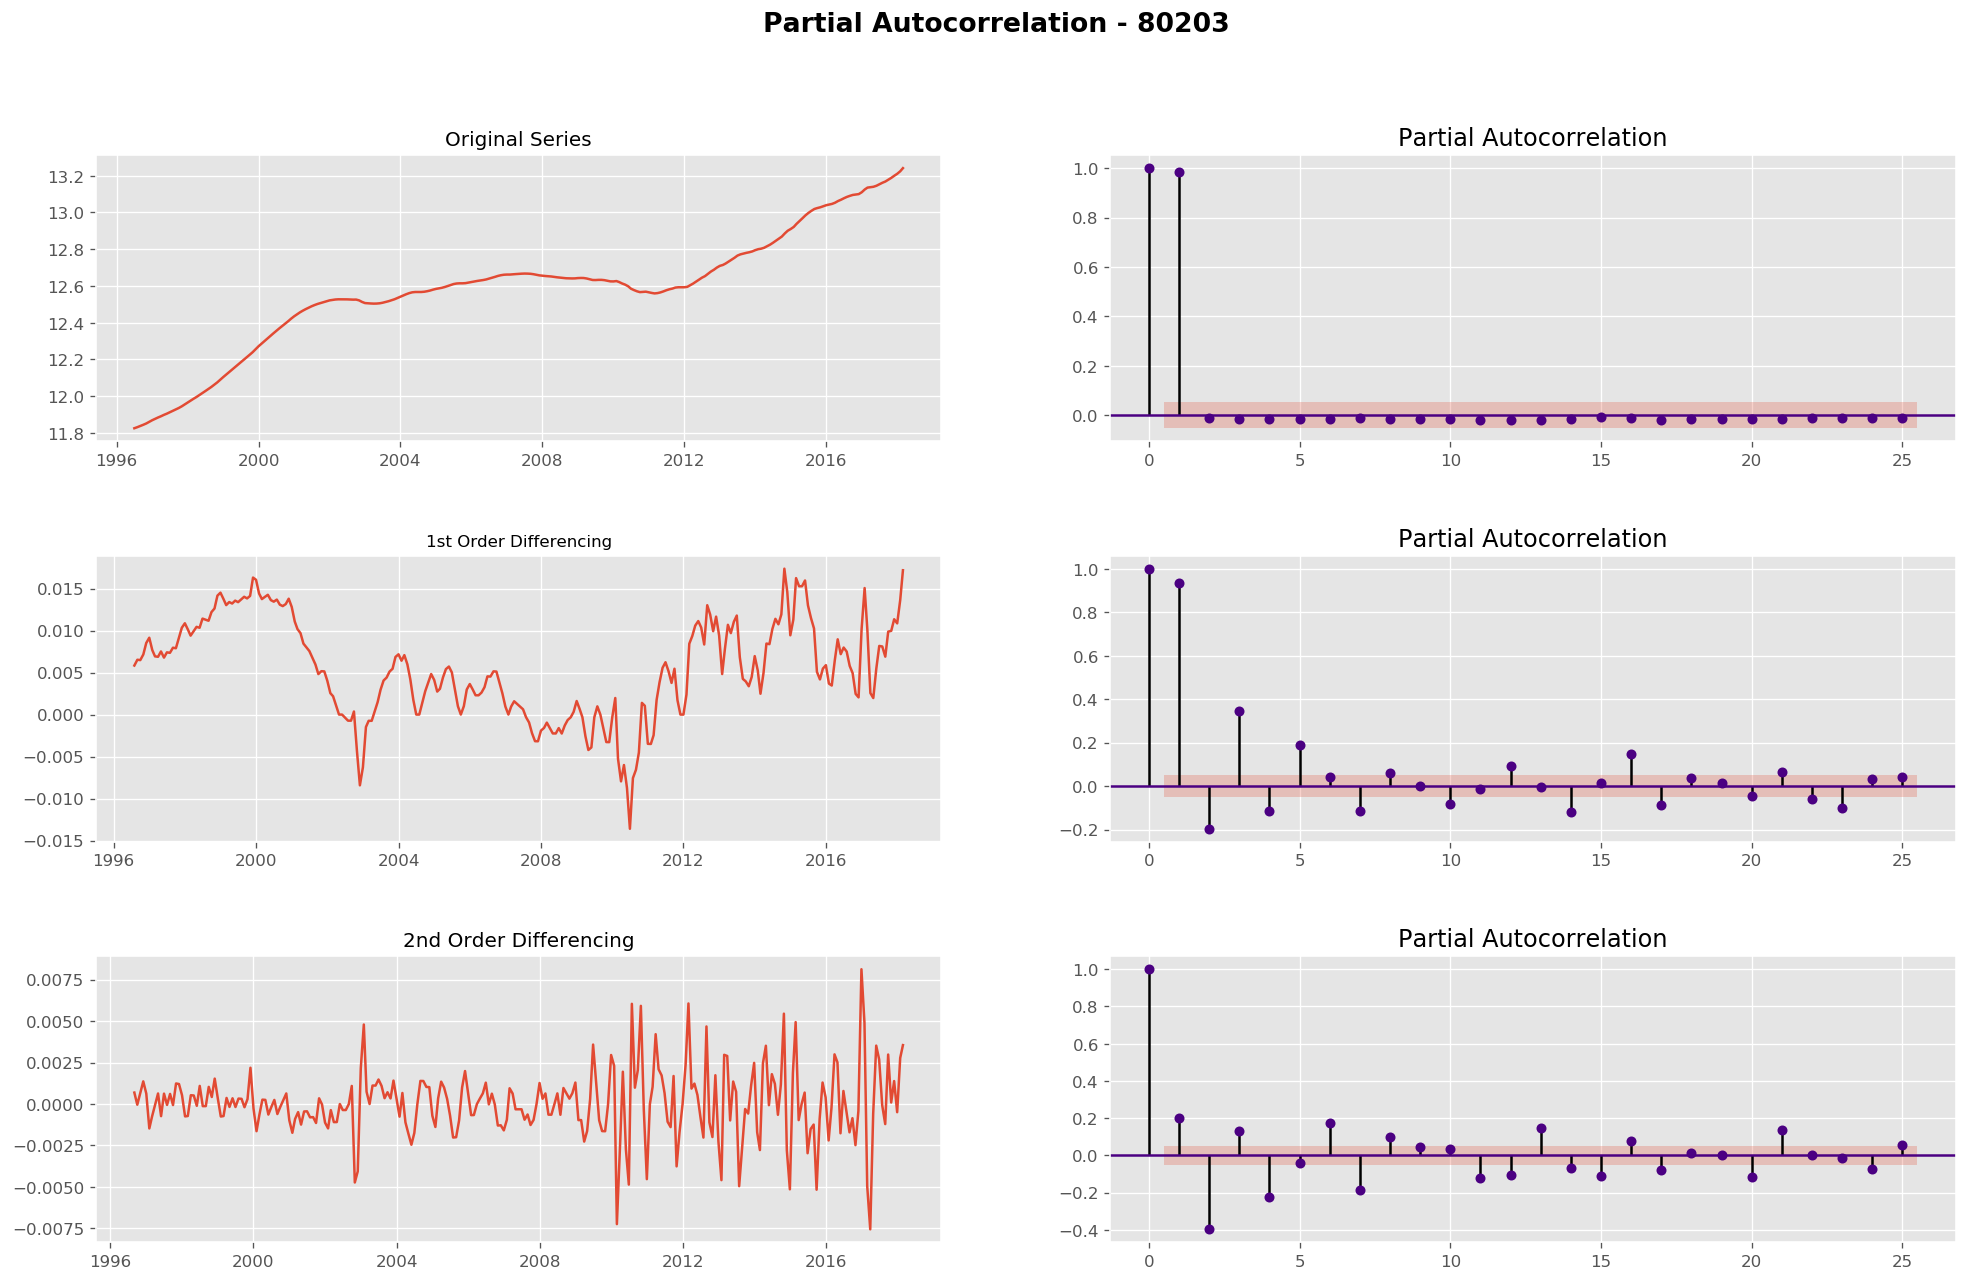

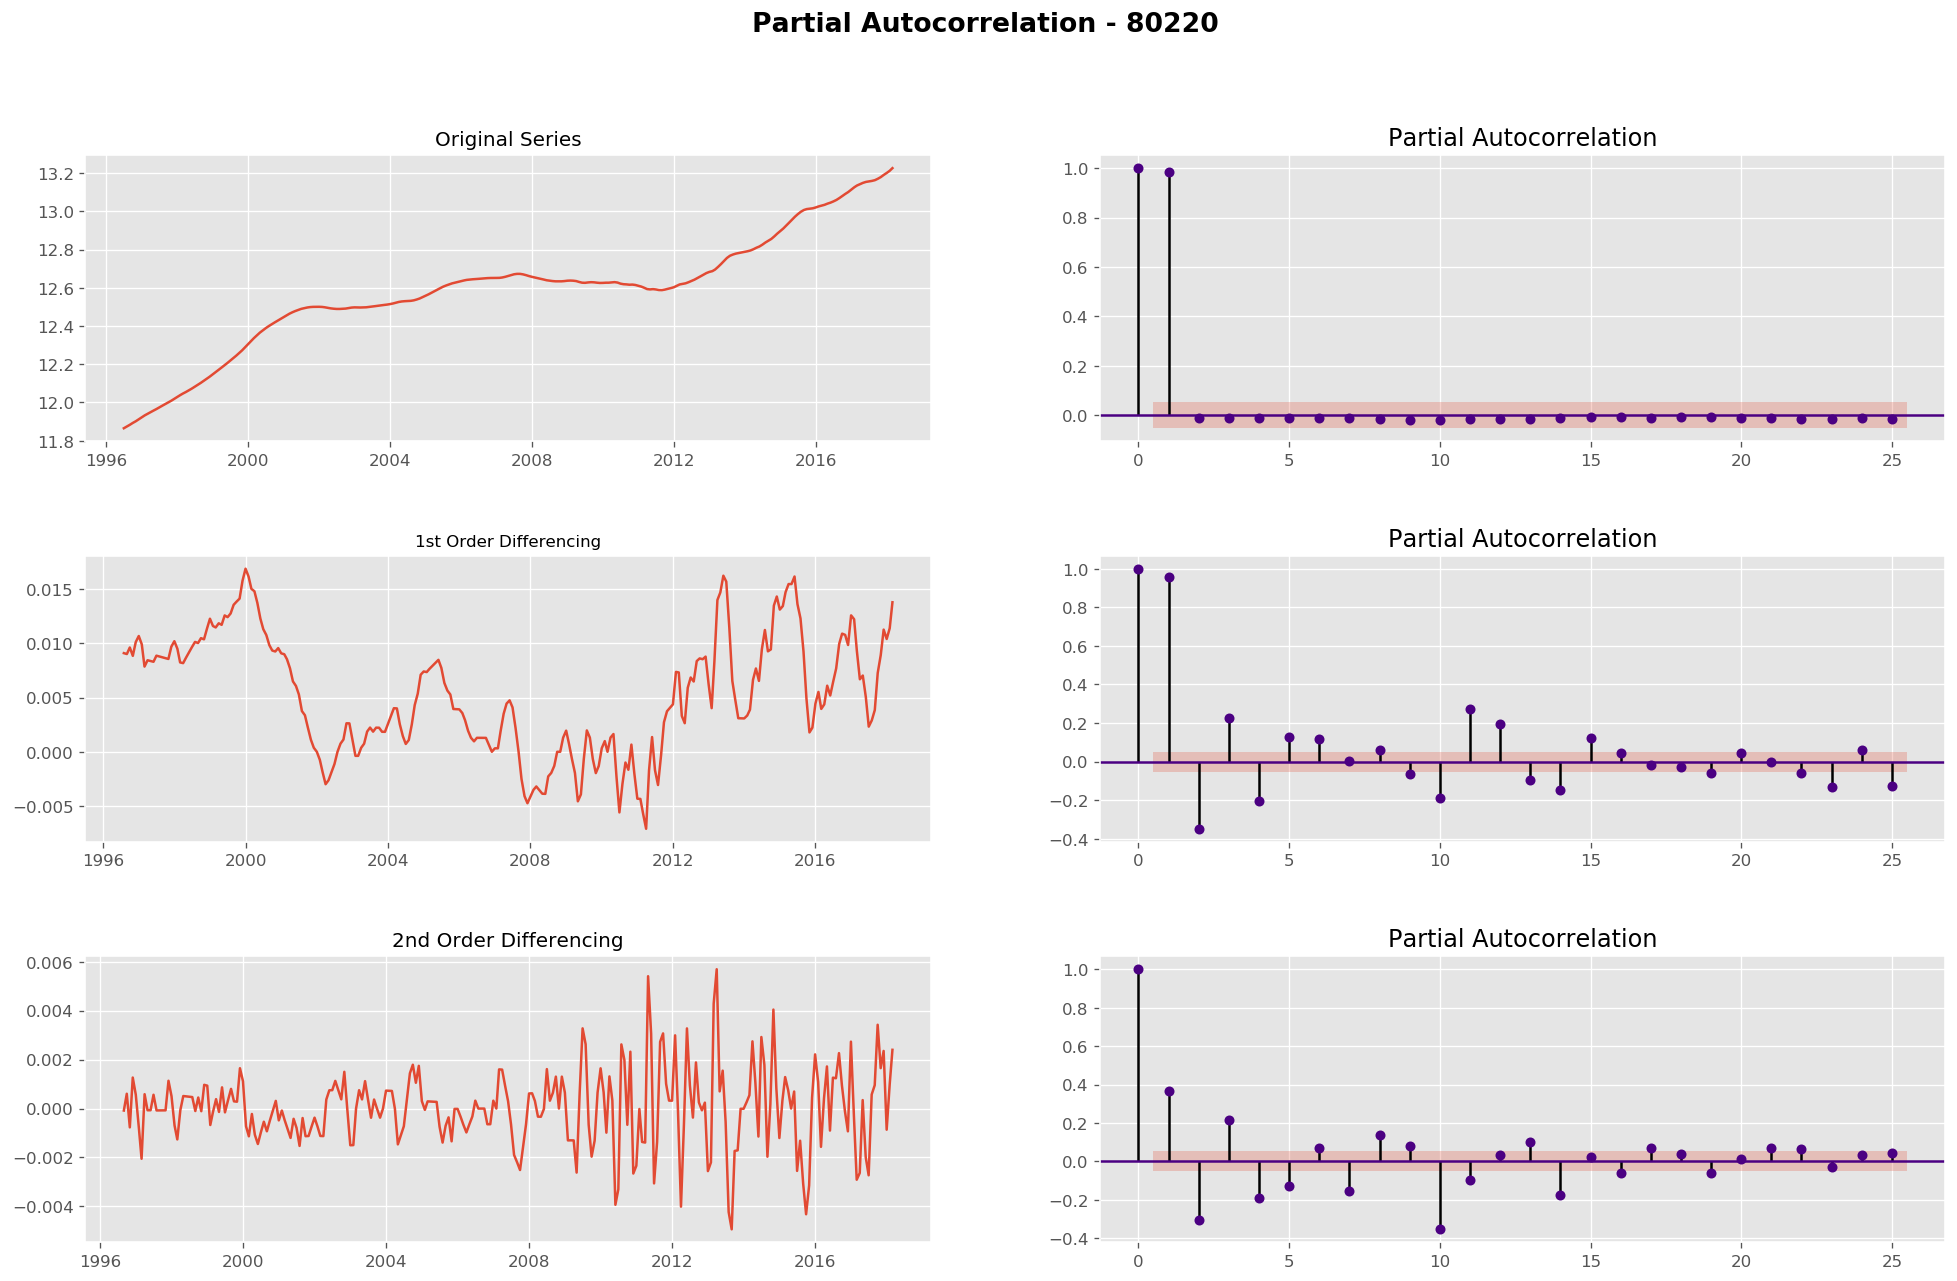

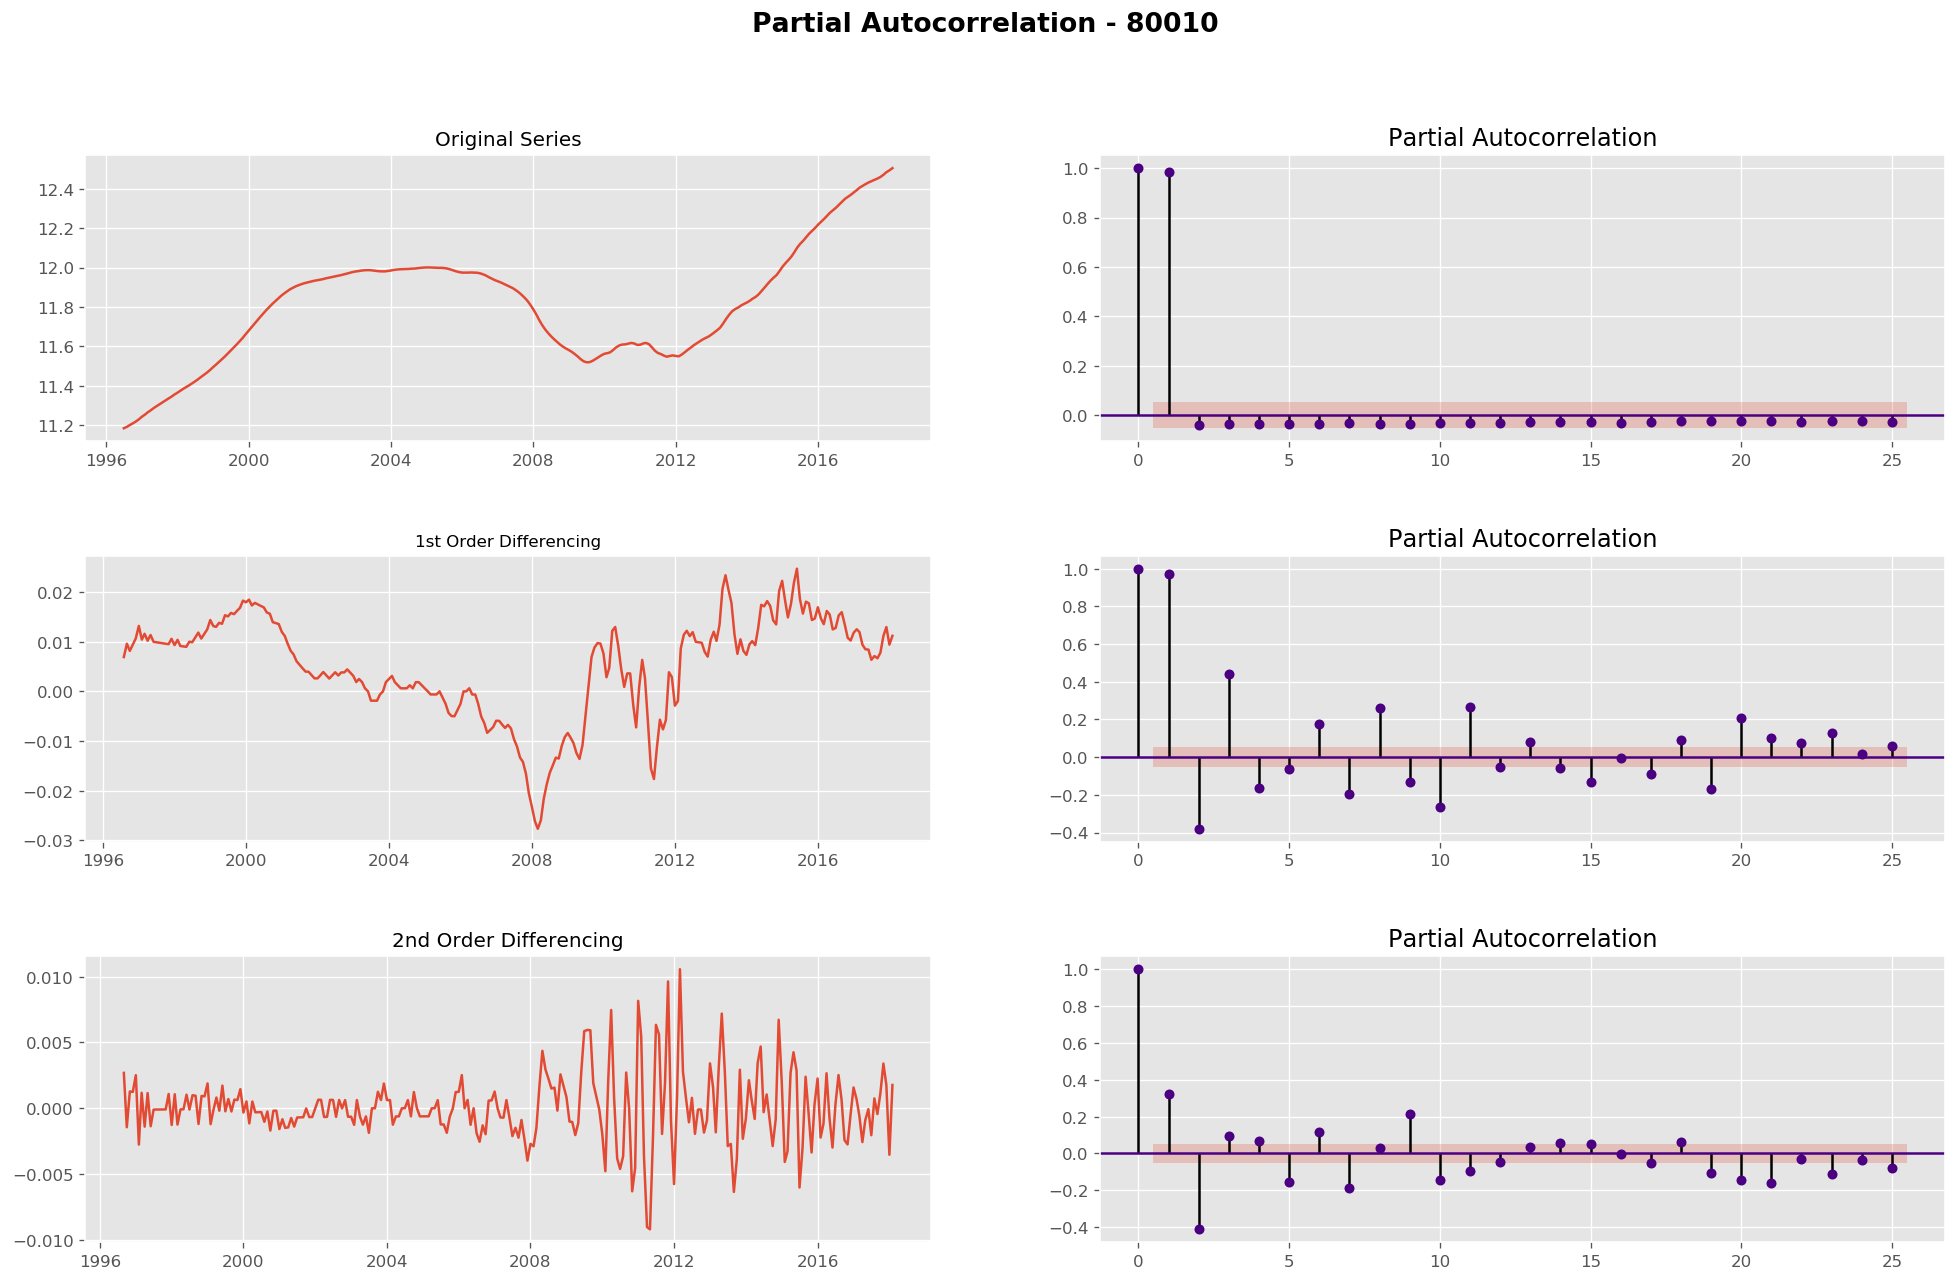

In [28]:
#The time series reaches stationarity with two orders of differencing.
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(20,12), 'figure.dpi':120})

for z in top5_zip: 
    dts_corr = dts_transform[dts_transform.RegionName == z]
    
    fig, axes = plt.subplots(3, 2)
    axes[0, 0].plot(dts_corr.ts_log); axes[0, 0].set_title('Original Series',fontsize=12)
    plot_pacf(dts_corr.ts_log, ax=axes[0, 1], color='indigo',alpha=0.4)

    # 1st Differencing
    axes[1, 0].plot(dts_corr.ts_log.diff()); axes[1, 0].set_title('1st Order Differencing',fontsize=10)
    plot_pacf(dts_corr.ts_log.diff().dropna(), ax=axes[1, 1], color='indigo',alpha=0.4)

    # 2nd Differencing
    axes[2, 0].plot(dts_corr.ts_log.diff().diff()); axes[2, 0].set_title('2nd Order Differencing',fontsize=12)
    plot_pacf(dts_corr.ts_log.diff().diff().dropna(), color='indigo',alpha=0.4, ax=axes[2, 1])

    fig.suptitle('Partial Autocorrelation - ' + str(z), fontsize=16, fontweight='bold')
    plt.subplots_adjust(hspace = 0.4 )
    plt.show()



## Decomposition: trend, seasonality, residuals
**Looking at our data:**
- De-trending and de-seasonalizing made the data (i.e., the residuals) more stationary over time. Based on **Dickey-Fuller test**, because p = < 0.05, we fail to reject the null hypothesis (that the time series is not stationary) at the p = 0.05 level, thus concluding that the **time series is stationary**.

# Evaluate Models

# Model the time-series data using ARIMA 

**ARIMA = Auto-Regressive Integrated Moving Average**.   
**Assumptions.** The time-series is stationary.  
**Depends on:**  
  **1. Number of AR (Auto-Regressive) terms (p).**  
  **2. Number of I (Integrated or Difference) terms (d).**  
  **3. Number of MA (Moving Average) terms (q).**  
## ACF and PACF Plots
**How do we determine p, d, and q?**
For p and q, we can use ACF and PACF plots 

**Autocorrelation Function (ACF).** Correlation between the time series with a lagged version of itself (e.g., correlation of Y(t) with Y(t-1)).

**Partial Autocorrelation Function (PACF).** Additional correlation explained by each successive lagged term.

**How do we interpret ACF and PACF plots?**
- p – Lag value where the PACF chart crosses the upper confidence interval for the first time.
- q – Lag value where the ACF chart crosses the upper confidence interval for the first time.


## Transformation, Smoothing, and Differencing
**Looking at our data:**
- Applying log transformation, weekly moving average smoothing, and differencing made the data more stationary over time. Based on **Dickey-Fuller test**, because p = < 0.05, we fail to reject the null hypothesis (that the time series is not stationary) at the p = 0.05 level, thus concluding that the **time series is stationary**.



In [29]:
def plot_acf_pacf(df, ts):
  """
  Plot auto-correlation function (ACF) and partial auto-correlation (PACF) plots
  """
  f, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 5)) 

  #Plot ACF: 

  ax1.plot(lag_acf)
  ax1.axhline(y=0,linestyle='--',color='gray')
  ax1.axhline(y=-1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax1.axhline(y=1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax1.set_title('Autocorrelation Function for %s' %(ts))

  #Plot PACF:
  ax2.plot(lag_pacf)
  ax2.axhline(y=0,linestyle='--',color='gray')
  ax2.axhline(y=-1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax2.axhline(y=1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')

  ax2.set_title('Partial Autocorrelation Function for %s' %(ts))
  
  plt.tight_layout()
  plt.show()
  plt.close()
  
  return

Zip: 80211


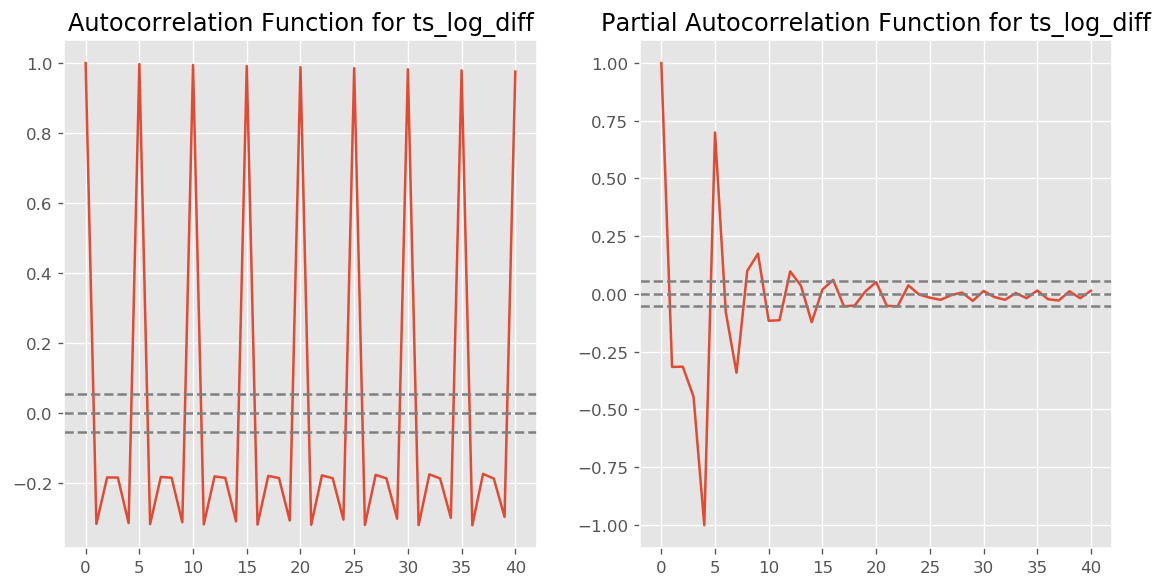

Zip: 80238


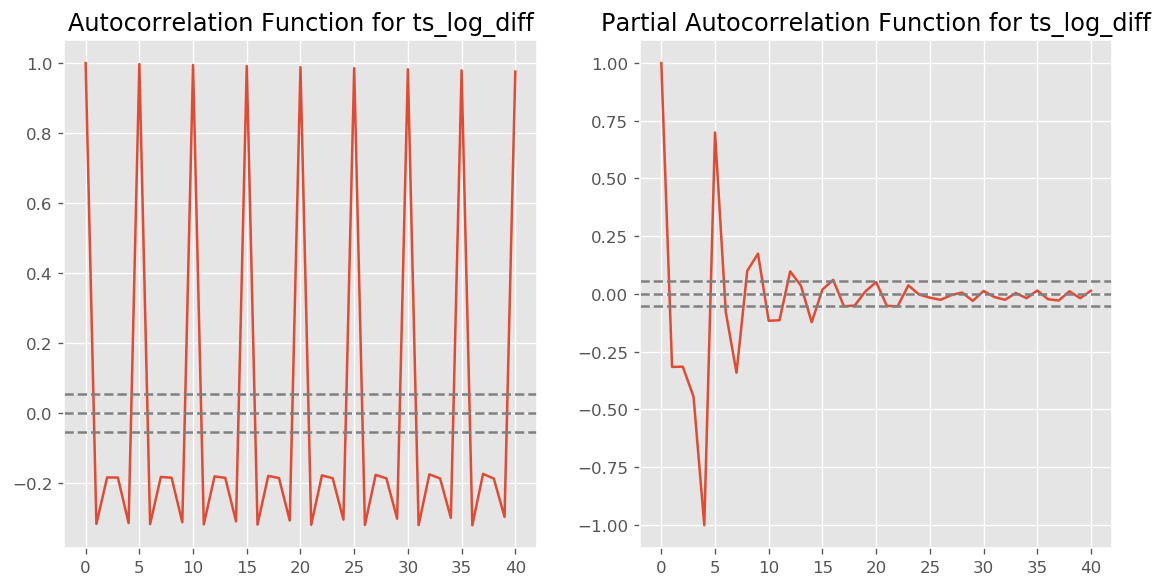

Zip: 80203


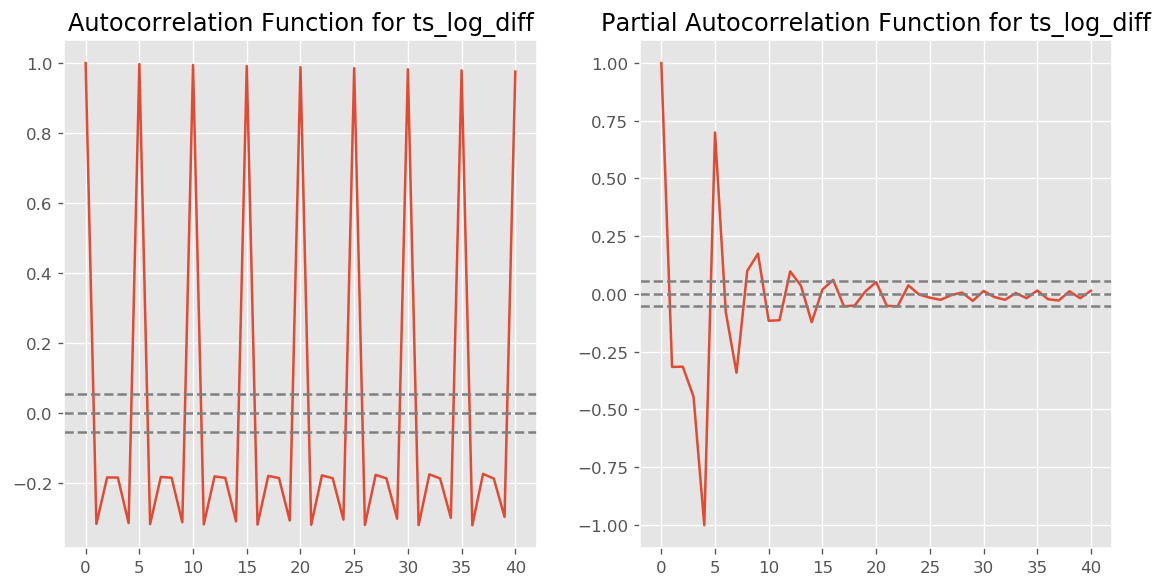

Zip: 80220


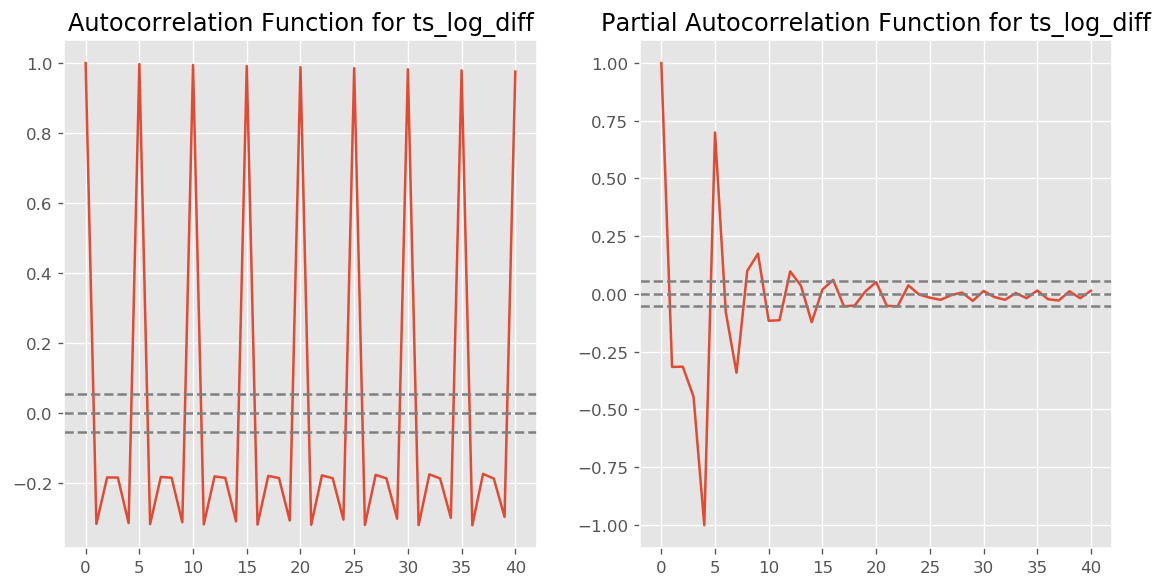

Zip: 80010


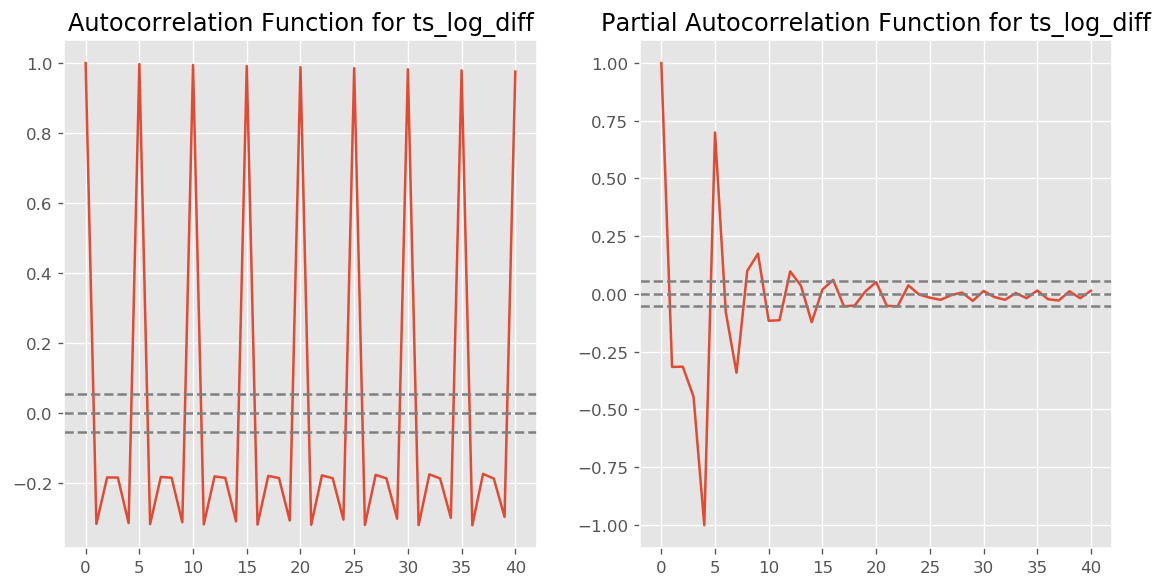

In [30]:
#ACF and PACF plots: Find value of P & Q
from statsmodels.tsa.stattools import acf, pacf

for z in top5_zip: 
    df = dts_transform[dts_transform.RegionName == z]
    print('Zip:', z)   
# determine ACF and PACF
    lag_acf = acf(np.array(dts_transform['ts_log_diff']))
    lag_pacf = pacf(np.array(dts_transform['ts_log_diff']))

    # plot ACF and PACF
    plot_acf_pacf(df = dts_transform, ts = 'ts_log_diff')

# Forecast Models

Zip:  80211
ADF Statistic Residual: -4.155746
p-value: 0.000782
Fit ARIMA: order=(1, 2, 1); AIC=3906.117, BIC=3920.329, Fit time=0.092 seconds
Fit ARIMA: order=(0, 2, 0); AIC=3970.791, BIC=3977.897, Fit time=0.003 seconds
Fit ARIMA: order=(1, 2, 0); AIC=3947.931, BIC=3958.590, Fit time=0.044 seconds
Fit ARIMA: order=(0, 2, 1); AIC=3905.184, BIC=3915.843, Fit time=0.048 seconds
Fit ARIMA: order=(0, 2, 2); AIC=3904.279, BIC=3918.491, Fit time=0.032 seconds
Fit ARIMA: order=(1, 2, 3); AIC=3872.321, BIC=3893.639, Fit time=0.237 seconds
Fit ARIMA: order=(0, 2, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 2, 3); AIC=3871.890, BIC=3896.760, Fit time=0.274 seconds
Fit ARIMA: order=(2, 2, 2); AIC=3870.067, BIC=3891.385, Fit time=0.215 seconds
Fit ARIMA: order=(3, 2, 3); AIC=3868.604, BIC=3897.027, Fit time=0.381 seconds
Fit ARIMA: order=(4, 2, 3); AIC=3867.281, BIC=3899.258, Fit time=0.491 seconds
Fit ARIMA: order=(4, 2, 2); AIC=3865.032, BIC=3893.456, Fit time=0.341 seconds


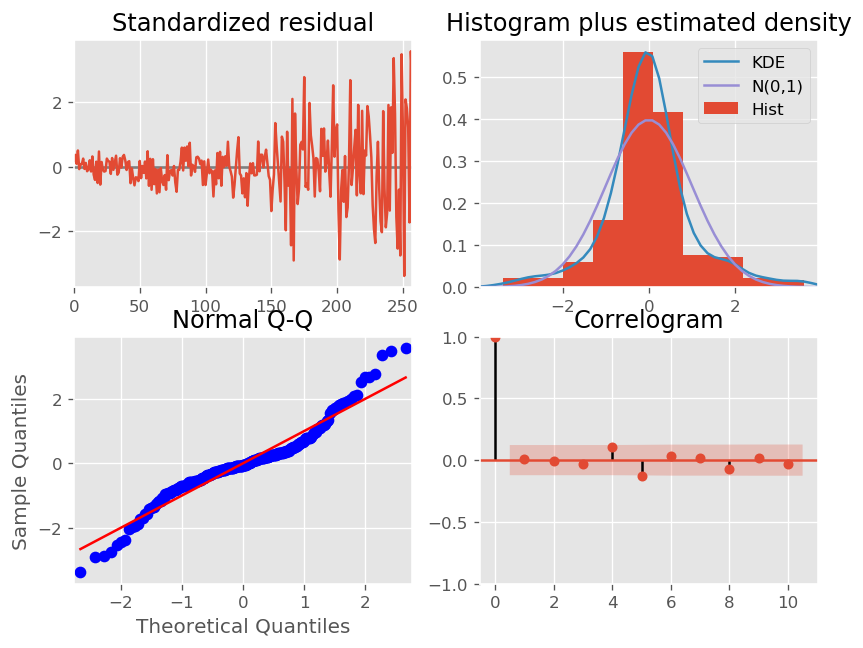

/Users/rndatasc/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/rndatasc/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


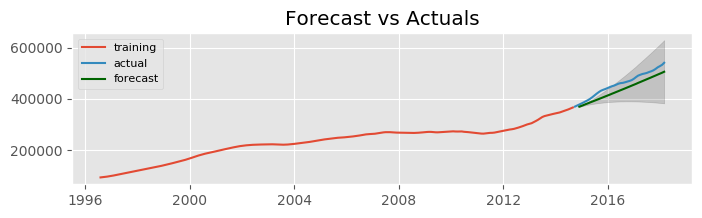

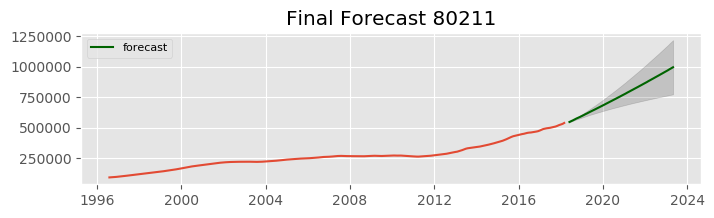

Zip:  80238
ADF Statistic Residual: -4.874105
p-value: 0.000039
Fit ARIMA: order=(1, 2, 1); AIC=4150.750, BIC=4164.962, Fit time=0.087 seconds
Fit ARIMA: order=(0, 2, 0); AIC=4202.464, BIC=4209.570, Fit time=0.002 seconds
Fit ARIMA: order=(1, 2, 0); AIC=4179.748, BIC=4190.407, Fit time=0.041 seconds
Fit ARIMA: order=(0, 2, 1); AIC=4149.372, BIC=4160.031, Fit time=0.061 seconds
Fit ARIMA: order=(0, 2, 2); AIC=4149.407, BIC=4163.619, Fit time=0.087 seconds
Fit ARIMA: order=(1, 2, 2); AIC=4139.856, BIC=4157.620, Fit time=0.161 seconds
Fit ARIMA: order=(2, 2, 2); AIC=4104.591, BIC=4125.909, Fit time=0.273 seconds
Fit ARIMA: order=(2, 2, 1); AIC=4133.726, BIC=4151.491, Fit time=0.121 seconds
Fit ARIMA: order=(2, 2, 3); AIC=4101.528, BIC=4126.398, Fit time=0.364 seconds
Fit ARIMA: order=(3, 2, 4); AIC=4100.789, BIC=4132.766, Fit time=1.547 seconds
Fit ARIMA: order=(2, 2, 4); AIC=4100.481, BIC=4128.905, Fit time=0.791 seconds
Fit ARIMA: order=(2, 2, 5); AIC=nan, BIC=nan, Fit time=nan seconds


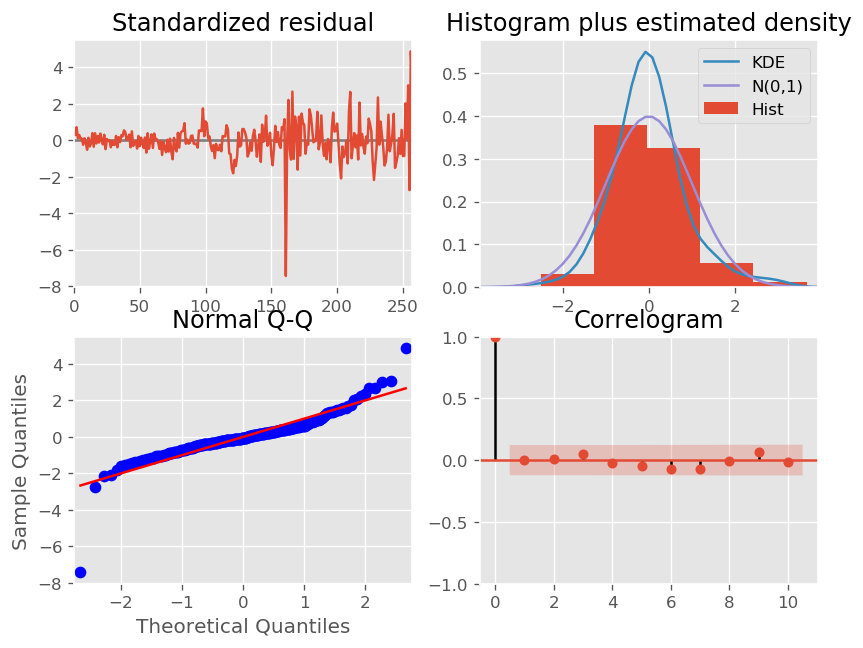

/Users/rndatasc/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/rndatasc/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


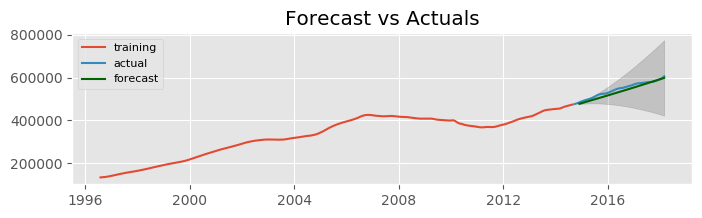

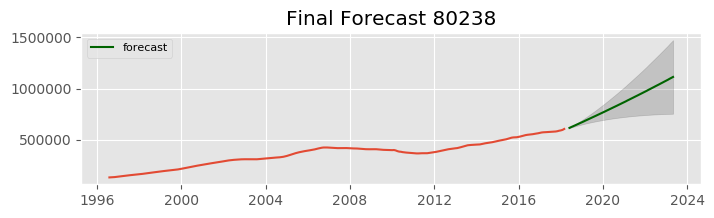

Zip:  80203
ADF Statistic Residual: -3.793925
p-value: 0.002970
Fit ARIMA: order=(1, 2, 1); AIC=4127.577, BIC=4141.804, Fit time=0.106 seconds
Fit ARIMA: order=(0, 2, 0); AIC=4174.658, BIC=4181.771, Fit time=0.002 seconds
Fit ARIMA: order=(1, 2, 0); AIC=4163.786, BIC=4174.457, Fit time=0.048 seconds
Fit ARIMA: order=(0, 2, 1); AIC=4130.671, BIC=4141.342, Fit time=0.029 seconds
Fit ARIMA: order=(2, 2, 1); AIC=4101.517, BIC=4119.302, Fit time=0.105 seconds
Fit ARIMA: order=(2, 2, 0); AIC=4105.253, BIC=4119.481, Fit time=0.101 seconds
Fit ARIMA: order=(2, 2, 2); AIC=4102.135, BIC=4123.476, Fit time=0.176 seconds
Fit ARIMA: order=(3, 2, 2); AIC=4102.109, BIC=4127.007, Fit time=0.266 seconds
Fit ARIMA: order=(3, 2, 1); AIC=4103.399, BIC=4124.740, Fit time=0.154 seconds
Total fit time: 0.989 seconds
80203
                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  259
Model:                 ARIMA(2,

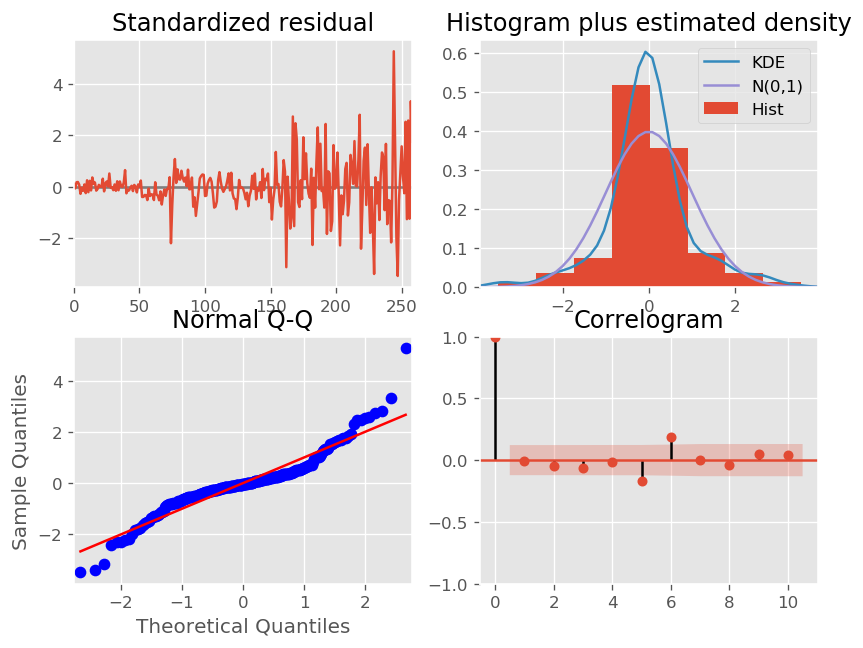

/Users/rndatasc/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/rndatasc/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


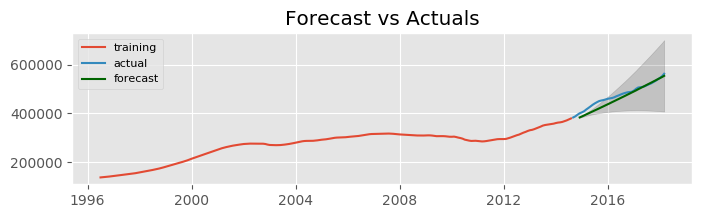

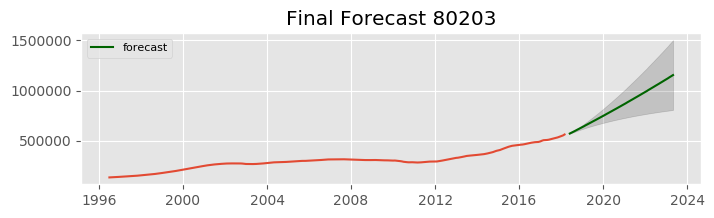

Zip:  80220
ADF Statistic Residual: -3.421644
p-value: 0.010243
Fit ARIMA: order=(1, 2, 1); AIC=3944.559, BIC=3958.786, Fit time=0.086 seconds
Fit ARIMA: order=(0, 2, 0); AIC=4004.252, BIC=4011.365, Fit time=0.002 seconds
Fit ARIMA: order=(1, 2, 0); AIC=3965.484, BIC=3976.154, Fit time=0.042 seconds
Fit ARIMA: order=(0, 2, 1); AIC=3942.584, BIC=3953.254, Fit time=0.041 seconds
Fit ARIMA: order=(0, 2, 2); AIC=3944.547, BIC=3958.774, Fit time=0.054 seconds
Fit ARIMA: order=(1, 2, 2); AIC=3939.333, BIC=3957.117, Fit time=0.152 seconds
Fit ARIMA: order=(2, 2, 2); AIC=3922.365, BIC=3943.706, Fit time=0.406 seconds
Fit ARIMA: order=(2, 2, 1); AIC=3944.002, BIC=3961.787, Fit time=0.103 seconds
Fit ARIMA: order=(2, 2, 3); AIC=3927.912, BIC=3952.810, Fit time=0.308 seconds
Fit ARIMA: order=(3, 2, 3); AIC=3921.614, BIC=3950.068, Fit time=0.444 seconds
Fit ARIMA: order=(4, 2, 3); AIC=3918.238, BIC=3950.250, Fit time=0.380 seconds
Fit ARIMA: order=(4, 2, 2); AIC=3930.469, BIC=3958.924, Fit time=0.

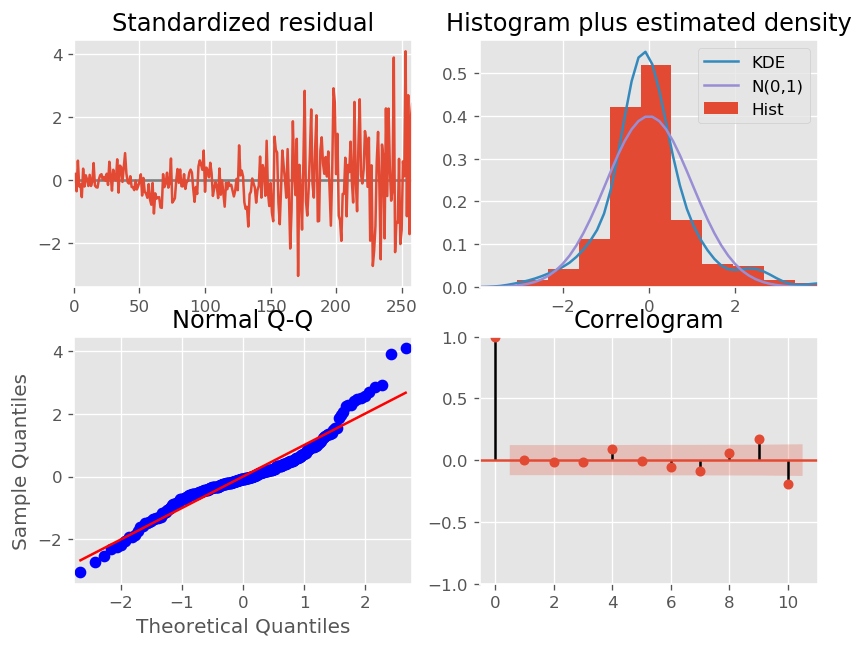

/Users/rndatasc/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/rndatasc/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/rndatasc/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


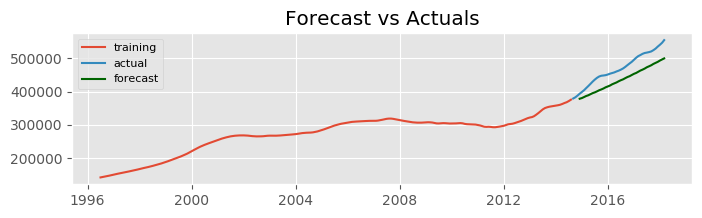

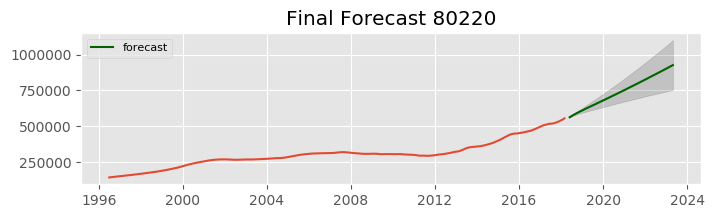

Zip:  80010
ADF Statistic Residual: -3.297446
p-value: 0.014993
Fit ARIMA: order=(1, 2, 1); AIC=3689.764, BIC=3703.975, Fit time=0.100 seconds
Fit ARIMA: order=(0, 2, 0); AIC=3736.546, BIC=3743.652, Fit time=0.003 seconds
Fit ARIMA: order=(1, 2, 0); AIC=3718.232, BIC=3728.891, Fit time=0.045 seconds
Fit ARIMA: order=(0, 2, 1); AIC=3688.998, BIC=3699.657, Fit time=0.041 seconds
Fit ARIMA: order=(0, 2, 2); AIC=3686.979, BIC=3701.190, Fit time=0.081 seconds
Fit ARIMA: order=(1, 2, 3); AIC=3656.006, BIC=3677.324, Fit time=0.190 seconds
Fit ARIMA: order=(0, 2, 3); AIC=3657.779, BIC=3675.544, Fit time=0.112 seconds
Fit ARIMA: order=(2, 2, 3); AIC=3655.180, BIC=3680.051, Fit time=0.293 seconds
Fit ARIMA: order=(2, 2, 2); AIC=3656.686, BIC=3678.004, Fit time=0.191 seconds
Fit ARIMA: order=(2, 2, 4); AIC=3657.081, BIC=3685.504, Fit time=0.446 seconds
Fit ARIMA: order=(1, 2, 2); AIC=3682.166, BIC=3699.931, Fit time=0.130 seconds
Fit ARIMA: order=(3, 2, 4); AIC=nan, BIC=nan, Fit time=nan seconds


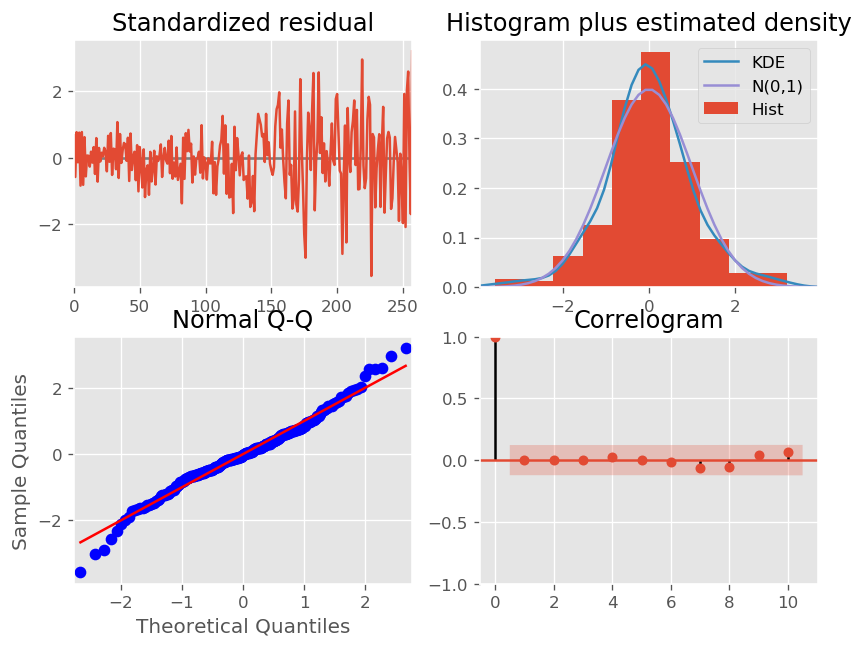

/Users/rndatasc/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/rndatasc/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


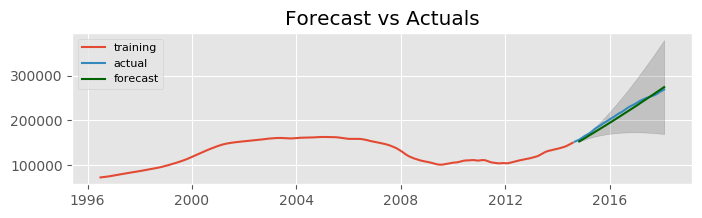

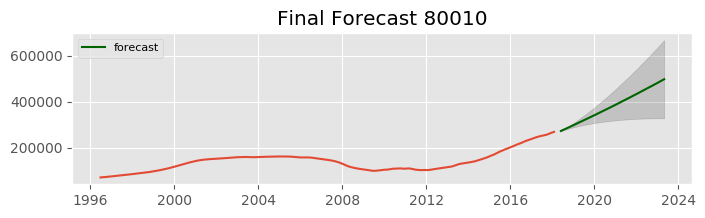

In [31]:
#https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
# compute residuals and create an ARMA model of the residuals.
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

residuals_list = []
for z in top5_zip:  
    df_z = dts_transform[dts_transform.RegionName == z]
    ts = df_z.ts
    decomposition = seasonal_decompose(np.log(ts))

    # Gather the trend, seasonality and noise of decomposed object
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    df_z['residual'] = residual
    residuals_list.append(residual)
    
    result = adfuller(residual.dropna())
    print('Zip: ', z)
    print('ADF Statistic Residual: %f' % result[0])
    print('p-value: %f' % result[1])
    plt.show()
    
    #Build Model
    #Use a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model (< AIC)
    model = pm.auto_arima(df_z.ts.dropna(), start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=12,              # frequency of series
                      d=2,          
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore', 
                      suppress_warnings=True, 
                      stepwise=True)
    print(z)
    print(model.summary())
    model.plot_diagnostics(figsize=(8, 6))
    plt.show()
    

    # Create Training and Test
    #create the train and test dataset by splitting the time series into 2 contiguous parts in approximately 60:40 ratio or a reasonable proportion based on time frequency of series.

    train = df_z.ts[:218]
    test = df_z.ts[218:]
    
    test_index = df_z.index[-40:]
    model2 = ARIMA(train, order=model.order)
    fitted = model2.fit(disp=-1)  
                   
    # Forecast
    fc, se, conf = fitted.forecast(40, alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_index)
    lower_series = pd.Series(conf[:, 0], index=test_index)
    upper_series = pd.Series(conf[:, 1], index=test_index)

    # Plot
    plt.figure(figsize=(8,2), dpi=100)
    plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(fc_series, color='darkgreen',label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

    #Forecast - 5 years in the future

    n_periods = 60
    fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range('2018-05-01', periods=60, freq='M')
    
    # make series for plotting purpose
    fc_series = pd.Series(fc, index=(index_of_fc))
    lower_series = pd.Series(confint[:, 0], index=(index_of_fc))
    upper_series = pd.Series(confint[:, 1], index=(index_of_fc))

    # Plot
    plt.figure(figsize=(8,2), dpi=100)
    plt.plot(fc_series, color='darkgreen',label='forecast')
    plt.plot(df_z.ts)
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color='k', alpha=.15)

    plt.title("Final Forecast " + str(z) )
    plt.legend(loc='upper left', fontsize=8)
    plt.show()


## Conclusion

The Top 5 zip codes are all in Colorado State:
+ 80211  
+ 80238  
+ 80203  
+ 80220  
+ 80010  

These are the zip codes that have the greatest return on investment (ROI) but with low volatility as evidenced by low variation.  

Please note that ROI can be impacted by:  
+ Real return over nominal Return  
+ Transaction cost  
+ 20% capital gain tax or more  
+ 5 years compounded rate  
+ Inflation  
+ Other fees/expense
+ Opportunity cost  


## Recommendations for Future Work


+ Get current Zillow data on monthly home price.
+ Review the Federal Housing Finance Agency House Price Index to project what a real estate investment would be worth today if appreciated at the average appreciation rate of all homes in Denver Colorado
+ Create models using traditional statistical models e.g. Regression-based models, *multi-variate models, random forest regression, decision trees 